# Detección de Intrusiones y Análisis de Anomalías en Tráfico de Red mediante Técnicas Estadísticas

**Universidad de La Habana, MATCOM**  
**Curso:** Estadística 2025-2026  
**Proyecto Final:** Análisis Estadístico Aplicado a Seguridad Informática

---

## 1. Introducción al Proyecto

### 1.1 Contexto y Motivación

La seguridad informática es uno de los pilares fundamentales en la infraestructura tecnológica moderna. Los Sistemas de Detección de Intrusiones (IDS) tradicionales, basados en firmas conocidas, presentan limitaciones significativas frente a ataques emergentes o modificados (zero-day attacks). 

Este proyecto propone un enfoque complementario basado en **análisis estadístico del comportamiento del tráfico de red**, permitiendo identificar patrones anómalos sin depender exclusivamente de firmas previamente catalogadas. Este tipo de aproximación resulta especialmente relevante en entornos dinámicos donde los ataques evolucionan constantemente.

### 1.2 Objetivos del Análisis

Este estudio busca responder **tres preguntas de investigación fundamentales**:

**Pregunta 1 (Análisis Comparativo):** ¿Existen diferencias estadísticamente significativas en el comportamiento de variables de flujo de red —como `src_bytes`, `dst_bytes` y `duration`— entre el tráfico normal y los distintos tipos de ataques (DoS, Probe, R2L y U2R)?

**Pregunta 2 (Reducción Dimensional):** ¿Es posible reducir la dimensionalidad de las 41 características del tráfico de red mediante Análisis de Componentes Principales (PCA), conservando al menos el 95% de la varianza explicada, y cómo impacta esta reducción en la visualización y separación de los distintos tipos de ataques?

**Pregunta 3 (Clasificación Comparativa):** ¿Qué técnica de clasificación estadística, Regresión Logística o K-Vecinos más Cercanos (K-NN), ofrece una mayor sensibilidad para detectar ataques raros (como U2R) en comparación con ataques volumétricos más comunes (como DoS)?

### 1.3 Dataset: NSL-KDD

**Fuente:** [NSL-KDD en Kaggle](https://www.kaggle.com/datasets/hassan06/nslkdd)

El dataset NSL-KDD es una versión refinada del clásico KDD Cup 1999, diseñada específicamente para eliminar redundancias y sesgos presentes en el conjunto original. Es ampliamente reconocido como estándar académico para la evaluación de algoritmos de detección de intrusiones.

**Características principales:**
- **41 variables predictoras** + 1 variable objetivo (`attack_type`) + 1 nivel de dificultad
- **Tipos de ataques:** Normal, DoS (Denial of Service), Probe (escaneo/sondeo), R2L (Remote to Local), U2R (User to Root)
- **Conjunto de entrenamiento:** 25,192 observaciones
- **Conjunto de prueba:** 22,544 observaciones

**Categorización de variables:**
- **Básicas:** Derivadas de cabeceras TCP/IP (duration, protocol_type, src_bytes, dst_bytes, flag)
- **De contenido:** Información sobre el payload (num_failed_logins, root_shell, etc.)
- **De tráfico:** Estadísticas temporales orientadas a detectar patrones (count, serror_rate, etc.)

---

## 1.4 Carga de Datos y Preparación Inicial

### Imports y Configuración

In [59]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuración de visualizaciones
warnings.filterwarnings('ignore')
%matplotlib inline

# Estilo global para mantener consistencia en todas las visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Paleta de colores consistente para categorías de ataque
# Se utilizará en todas las visualizaciones del proyecto
attack_colors = {
    'Normal': '#2ecc71',    # Verde - Tráfico legítimo
    'DoS': '#e74c3c',       # Rojo - Ataques de denegación de servicio
    'Probe': '#f39c12',     # Naranja - Ataques de reconocimiento
    'R2L': '#9b59b6',       # Morado - Acceso remoto no autorizado
    'U2R': '#34495e'        # Gris oscuro - Escalada de privilegios
}

print("✅ Librerías importadas y configuración de visualización establecida")

✅ Librerías importadas y configuración de visualización establecida


### Carga de Datos

In [60]:
# Definir los nombres de las columnas (43 columnas en total)
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "attack_type", "difficulty_level"
]

# Cargar los datasets
# Nota: Ajusta las rutas según tu estructura de carpetas
train_df = pd.read_csv('Data/KDDTrain+_20Percent.txt', 
                       names=col_names, 
                       header=None)

test_df = pd.read_csv('Data/KDDTest+.txt', 
                      names=col_names, 
                      header=None)

# Crear variable binaria para clasificación binaria (Normal vs. Ataque)
train_df['is_attack'] = (train_df['attack_type'] != 'normal').astype(int)
test_df['is_attack'] = (test_df['attack_type'] != 'normal').astype(int)

# Mostrar información básica
print(f"📊 Datos de entrenamiento: {train_df.shape}")
print(f"📊 Datos de prueba: {test_df.shape}")
print(f"\n✅ Datasets cargados exitosamente")

# Distribución binaria inicial
print(f"\n🎯 Distribución binaria en entrenamiento (Normal vs. Ataque):")
print(train_df['is_attack'].value_counts(normalize=True).round(4))

print(f"\n🎯 Distribución binaria en prueba (Normal vs. Ataque):")
print(test_df['is_attack'].value_counts(normalize=True).round(4))

📊 Datos de entrenamiento: (25192, 44)
📊 Datos de prueba: (22544, 44)

✅ Datasets cargados exitosamente

🎯 Distribución binaria en entrenamiento (Normal vs. Ataque):
is_attack
0    0.5339
1    0.4661
Name: proportion, dtype: float64

🎯 Distribución binaria en prueba (Normal vs. Ataque):
is_attack
1    0.5692
0    0.4308
Name: proportion, dtype: float64


## 1.5 Mapeo de Categorías de Ataque

El dataset NSL-KDD contiene 39 tipos de ataques específicos que se agrupan en 4 categorías principales más la clase normal. A continuación se realiza el mapeo oficial según la documentación del Canadian Institute for Cybersecurity:

- **Normal:** Tráfico de red legítimo
- **DoS (Denial of Service):** Ataques que buscan denegar el servicio mediante sobrecarga de recursos
- **Probe (Probing/Scanning):** Ataques de reconocimiento que escanean la red en busca de vulnerabilidades
- **R2L (Remote to Local):** Intentos de acceso no autorizado desde una máquina remota
- **U2R (User to Root):** Intentos de escalada de privilegios de usuario normal a superusuario

In [61]:
# Diccionario oficial de mapeo de ataques específicos a categorías generales
# Fuente: Documentación oficial NSL-KDD (Canadian Institute for Cybersecurity)
attack_category_mapping = {
    # Tráfico Normal
    'normal': 'Normal',
    
    # DoS (Denial of Service) - Ataques de denegación de servicio
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS',
    'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS',
    'processtable': 'DoS', 'udpstorm': 'DoS',
    
    # Probe (Probing/Scanning) - Ataques de reconocimiento
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    
    # R2L (Remote to Local) - Acceso no autorizado desde máquina remota
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L',
    'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L',
    'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L',
    'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L',
    
    # U2R (User to Root) - Escalada de privilegios
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R',
    'rootkit': 'U2R', 'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R'
}

# Aplicar mapeo a ambos datasets
train_df['attack_category'] = train_df['attack_type'].map(attack_category_mapping)
test_df['attack_category'] = test_df['attack_type'].map(attack_category_mapping)

# Verificar que no hay valores sin mapear
print("🔍 Verificación de mapeo de categorías:")
unmapped_train = train_df['attack_category'].isna().sum()
unmapped_test = test_df['attack_category'].isna().sum()
print(f"   Valores sin mapear en train: {unmapped_train}")
print(f"   Valores sin mapear en test: {unmapped_test}")

if unmapped_test > 0:
    print(f"\n⚠️ ADVERTENCIA: Hay {unmapped_test} ataques en test sin categoría asignada.")
    print("   Esto es esperado en NSL-KDD, que incluye ataques nuevos en el conjunto de prueba.")
    print("   Estos registros se filtrarán en análisis posteriores.")

# Crear orden categórico para visualizaciones consistentes
category_order = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
train_df['attack_category'] = pd.Categorical(
    train_df['attack_category'], 
    categories=category_order, 
    ordered=True
)
test_df['attack_category'] = pd.Categorical(
    test_df['attack_category'], 
    categories=category_order, 
    ordered=True
)

# Mostrar distribución de categorías
print("\n📊 Distribución de categorías en ENTRENAMIENTO:")
category_dist_train = train_df['attack_category'].value_counts()
category_pct_train = train_df['attack_category'].value_counts(normalize=True) * 100
category_summary_train = pd.DataFrame({
    'Frecuencia': category_dist_train,
    'Porcentaje': category_pct_train.round(2)
})
print(category_summary_train)

print("\n📊 Distribución de categorías en PRUEBA:")
category_dist_test = test_df[test_df['attack_category'].notna()]['attack_category'].value_counts()
category_pct_test = test_df[test_df['attack_category'].notna()]['attack_category'].value_counts(normalize=True) * 100
category_summary_test = pd.DataFrame({
    'Frecuencia': category_dist_test,
    'Porcentaje': category_pct_test.round(2)
})
print(category_summary_test)

print("\n✅ Mapeo de categorías completado exitosamente")

🔍 Verificación de mapeo de categorías:
   Valores sin mapear en train: 0
   Valores sin mapear en test: 13

⚠️ ADVERTENCIA: Hay 13 ataques en test sin categoría asignada.
   Esto es esperado en NSL-KDD, que incluye ataques nuevos en el conjunto de prueba.
   Estos registros se filtrarán en análisis posteriores.

📊 Distribución de categorías en ENTRENAMIENTO:
                 Frecuencia  Porcentaje
attack_category                        
Normal                13449       53.39
DoS                    9234       36.65
Probe                  2289        9.09
R2L                     209        0.83
U2R                      11        0.04

📊 Distribución de categorías en PRUEBA:
                 Frecuencia  Porcentaje
attack_category                        
Normal                 9711       43.10
DoS                    7458       33.10
R2L                    2754       12.22
Probe                  2421       10.75
U2R                     187        0.83

✅ Mapeo de categorías completado exit

## 1.6 Preparación de Muestra Estratificada para Visualizaciones

Para optimizar el rendimiento de visualizaciones complejas (como scatterplot matrices y pairplots), crearemos una muestra estratificada de 5,000 observaciones que mantenga las proporciones originales de cada categoría de ataque. 

**Nota importante:** Esta muestra se utilizará **exclusivamente para visualizaciones**. Todos los análisis estadísticos (correlaciones, pruebas de hipótesis, modelos) se realizarán sobre el dataset completo.

In [62]:
# Configuración del muestreo estratificado
sample_size = 5000
random_state = 42  # Para reproducibilidad

# Crear muestra estratificada manteniendo proporciones de cada categoría
train_sample = train_df.groupby('attack_category', group_keys=False).apply(
    lambda x: x.sample(
        n=min(len(x), int(sample_size * len(x) / len(train_df))),
        random_state=random_state
    )
).reset_index(drop=True)

print(f"📊 Muestra estratificada creada: {len(train_sample):,} observaciones")
print(f"\n✅ Verificación de estratificación:")

# Comparar proporciones originales vs. muestra
comparison = pd.DataFrame({
    'Original (%)': train_df['attack_category'].value_counts(normalize=True).sort_index() * 100,
    'Muestra (%)': train_sample['attack_category'].value_counts(normalize=True).sort_index() * 100
})
comparison['Diferencia (pp)'] = (comparison['Muestra (%)'] - comparison['Original (%)']).abs()
print(comparison.round(2))

print("\n💡 Esta muestra se usará únicamente para visualizaciones pesadas.")
print("   Los análisis estadísticos utilizarán el dataset completo.")

📊 Muestra estratificada creada: 4,998 observaciones

✅ Verificación de estratificación:
                 Original (%)  Muestra (%)  Diferencia (pp)
attack_category                                            
Normal                  53.39        53.40             0.02
DoS                     36.65        36.65             0.00
Probe                    9.09         9.08             0.00
R2L                      0.83         0.82             0.01
U2R                      0.04         0.04             0.00

💡 Esta muestra se usará únicamente para visualizaciones pesadas.
   Los análisis estadísticos utilizarán el dataset completo.


---

# 2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

El Análisis Exploratorio de Datos es fundamental para comprender la estructura, distribución y relaciones presentes en el dataset antes de aplicar técnicas estadísticas avanzadas. Esta sección cumple tres objetivos principales:

1. **Validar la calidad de los datos** y detectar problemas estructurales
2. **Fundamentar decisiones de preparación** que se implementarán en la sección 3
3. **Generar hipótesis preliminares** que guiarán las pruebas estadísticas posteriores

---

## 2.1 Información General del Dataset

En esta primera sección del EDA realizaremos una exploración estructural del dataset para verificar:
- Dimensiones y tipos de datos
- Presencia de valores nulos o faltantes
- Distribución de variables numéricas vs. categóricas
- Uso de memoria, consideraciones computacionales y duplicados

In [63]:
print("INFORMACIÓN ESTRUCTURAL DEL DATASET")

# 1. Dimensiones
print(f"\n📦 Dimensiones de los datasets:")
print(f"   Entrenamiento: {train_df.shape[0]:,} observaciones × {train_df.shape[1]} variables")
print(f"   Prueba: {test_df.shape[0]:,} observaciones × {test_df.shape[1]} variables")

# 2. Información de tipos de datos
print(f"\n🔢 Distribución de tipos de datos (Train):")
print(train_df.dtypes.value_counts())

# 3. Duplicados
print(f"\n🔁 REGISTROS DUPLICADOS:")
duplicates = train_df.duplicated().sum()
print(f"Filas duplicadas: {duplicates}")

# 4. Separación de variables numéricas y categóricas
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remover variables objetivo y auxiliares de las listas
numeric_cols = [col for col in numeric_cols if col not in ['is_attack', 'difficulty_level']]
categorical_cols = [col for col in categorical_cols if col not in ['attack_type', 'attack_category']]

print(f"\n📊 Clasificación de variables predictoras:")
print(f"   Variables numéricas: {len(numeric_cols)}")
print(f"   Variables categóricas: {len(categorical_cols)}")
print(f"   Total de predictoras: {len(numeric_cols) + len(categorical_cols)}")

print(f"\n   Variables categóricas identificadas:")
for col in categorical_cols:
    n_unique = train_df[col].nunique()
    print(f"      - {col}: {n_unique} categorías únicas")

INFORMACIÓN ESTRUCTURAL DEL DATASET

📦 Dimensiones de los datasets:
   Entrenamiento: 25,192 observaciones × 45 variables
   Prueba: 22,544 observaciones × 45 variables

🔢 Distribución de tipos de datos (Train):
int64       25
float64     15
object       4
category     1
Name: count, dtype: int64

🔁 REGISTROS DUPLICADOS:
Filas duplicadas: 0

📊 Clasificación de variables predictoras:
   Variables numéricas: 38
   Variables categóricas: 3
   Total de predictoras: 41

   Variables categóricas identificadas:
      - protocol_type: 3 categorías únicas
      - service: 66 categorías únicas
      - flag: 11 categorías únicas


In [64]:
# Verificación de valores nulos en variables predictoras originales
print("\n🔍 Verificación de valores faltantes:")

# Excluir attack_category del análisis de nulos (es variable derivada)
original_cols = [col for col in train_df.columns if col not in ['attack_category', 'is_attack']]
missing_train = train_df[original_cols].isnull().sum().sum()
missing_test = test_df[original_cols].isnull().sum().sum()

print(f"   Dataset de entrenamiento: {missing_train} valores nulos")
print(f"   Dataset de prueba: {missing_test} valores nulos")

if missing_train == 0 and missing_test == 0:
    print(f"\n   ✅ Excelente: No hay valores faltantes en las variables originales.")
    print(f"      No se requiere imputación de datos.")
else:
    print(f"\n   ⚠️ Se detectaron valores faltantes. Análisis detallado:")
    if missing_train > 0:
        print(f"\n   Columnas con valores nulos en TRAIN:")
        missing_cols_train = train_df[original_cols].isnull().sum()[train_df[original_cols].isnull().sum() > 0]
        print(missing_cols_train)
    if missing_test > 0:
        print(f"\n   Columnas con valores nulos en TEST:")
        missing_cols_test = test_df[original_cols].isnull().sum()[test_df[original_cols].isnull().sum() > 0]
        print(missing_cols_test)

# Aclaración sobre attack_category
missing_attack_cat = test_df['attack_category'].isna().sum()
if missing_attack_cat > 0:
    print(f"\n   ℹ️ Nota: {missing_attack_cat} observaciones en test no tienen 'attack_category' asignada.")
    print(f"      Esto se debe a que contienen tipos de ataque nuevos no presentes en train.")
    print(f"      Esta característica es intencional del dataset NSL-KDD para evaluar generalización.")


🔍 Verificación de valores faltantes:
   Dataset de entrenamiento: 0 valores nulos
   Dataset de prueba: 0 valores nulos

   ✅ Excelente: No hay valores faltantes en las variables originales.
      No se requiere imputación de datos.

   ℹ️ Nota: 13 observaciones en test no tienen 'attack_category' asignada.
      Esto se debe a que contienen tipos de ataque nuevos no presentes en train.
      Esta característica es intencional del dataset NSL-KDD para evaluar generalización.


In [65]:
# Uso de memoria y consideraciones computacionales
print("\n💾 Uso de memoria:")
train_memory_mb = train_df.memory_usage(deep=True).sum() / 1024**2
test_memory_mb = test_df.memory_usage(deep=True).sum() / 1024**2

print(f"   Dataset de entrenamiento: {train_memory_mb:.2f} MB")
print(f"   Dataset de prueba: {test_memory_mb:.2f} MB")
print(f"   Total en memoria: {train_memory_mb + test_memory_mb:.2f} MB")

if train_memory_mb + test_memory_mb < 100:
    print(f"\n   ✅ El dataset tiene un tamaño manejable para análisis completo.")
    print(f"      No se requieren técnicas especiales de optimización de memoria.")
else:
    print(f"\n   ⚠️ Dataset de tamaño considerable. Se recomienda:")
    print(f"      - Usar muestras estratificadas para visualizaciones pesadas")
    print(f"      - Monitorear uso de RAM durante análisis")


💾 Uso de memoria:
   Dataset de entrenamiento: 12.83 MB
   Dataset de prueba: 11.50 MB
   Total en memoria: 24.33 MB

   ✅ El dataset tiene un tamaño manejable para análisis completo.
      No se requieren técnicas especiales de optimización de memoria.


In [66]:
# Vista previa de los datos
print("\n📋 Primeras 5 observaciones del dataset de entrenamiento:")
display(train_df.head())

print("\n📋 Últimas 5 observaciones del dataset de entrenamiento:")
display(train_df.tail())


📋 Primeras 5 observaciones del dataset de entrenamiento:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level,is_attack,attack_category
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0,Normal



📋 Últimas 5 observaciones del dataset de entrenamiento:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level,is_attack,attack_category
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,1.0,1.0,neptune,19,1,DoS
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,1.00,0.18,0.0,0.0,0.0,0.0,warezclient,12,1,R2L
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21,1,DoS
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,0.00,0.00,1.0,1.0,0.0,0.0,neptune,20,1,DoS
25191,0,tcp,finger,S0,0,0,0,0,0,0,...,0.01,0.00,1.0,1.0,0.0,0.0,neptune,18,1,DoS


In [67]:
# Estadísticos descriptivos de variables clave
# Enfocándonos en las variables mencionadas en la Pregunta de Investigación 1
key_vars = ['duration', 'src_bytes', 'dst_bytes']

print("\n📈 Estadísticos descriptivos de variables clave (Dataset completo):")
print("\nEstas tres variables son centrales para la Pregunta de Investigación 1.")
print("Se analizará si presentan diferencias significativas entre tráfico normal y ataques.\n")

key_stats = train_df[key_vars].describe().T
key_stats['range'] = key_stats['max'] - key_stats['min']
key_stats['cv'] = (key_stats['std'] / key_stats['mean']) * 100  # Coeficiente de variación

display(key_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'cv']])

print("\n📊 Interpretación preliminar:")
for var in key_vars:
    mean_val = train_df[var].mean()
    median_val = train_df[var].median()
    max_val = train_df[var].max()
    cv = (train_df[var].std() / mean_val) * 100 if mean_val > 0 else 0
    
    print(f"\n   {var}:")
    print(f"      - Rango: 0 a {max_val:,.0f}")
    print(f"      - Media vs. Mediana: {mean_val:.2f} vs. {median_val:.2f}")
    
    if median_val == 0:
        print(f"      - ⚠️ Mediana en 0: Indica que >50% de las conexiones tienen {var}=0")
    
    if mean_val > median_val * 10 and median_val > 0:
        print(f"      - ⚠️ Asimetría positiva severa detectada (media >> mediana)")
        print(f"      - Probable presencia de outliers extremos")
        print(f"      - Recomendación: Considerar transformación logarítmica para visualización")
    
    if cv > 100:
        print(f"      - ⚠️ Coeficiente de variación muy alto ({cv:.1f}%)")
        print(f"      - Alta heterogeneidad en los datos")


📈 Estadísticos descriptivos de variables clave (Dataset completo):

Estas tres variables son centrales para la Pregunta de Investigación 1.
Se analizará si presentan diferencias significativas entre tráfico normal y ataques.



,count,mean,std,min,25%,50%,75%,max,range,cv
duration,25192.0,305.054104,2.686556e+03,0.0,0.0,0.0,0.00,42862.0,42862.0,880.681689
src_bytes,25192.0,24330.628215,2.410805e+06,0.0,0.0,44.0,279.00,381709090.0,381709090.0,9908.520983
dst_bytes,25192.0,3491.847174,8.883072e+04,0.0,0.0,0.0,530.25,5151385.0,5151385.0,2543.946339



📊 Interpretación preliminar:

   duration:
      - Rango: 0 a 42,862
      - Media vs. Mediana: 305.05 vs. 0.00
      - ⚠️ Mediana en 0: Indica que >50% de las conexiones tienen duration=0
      - ⚠️ Coeficiente de variación muy alto (880.7%)
      - Alta heterogeneidad en los datos

   src_bytes:
      - Rango: 0 a 381,709,090
      - Media vs. Mediana: 24330.63 vs. 44.00
      - ⚠️ Asimetría positiva severa detectada (media >> mediana)
      - Probable presencia de outliers extremos
      - Recomendación: Considerar transformación logarítmica para visualización
      - ⚠️ Coeficiente de variación muy alto (9908.5%)
      - Alta heterogeneidad en los datos

   dst_bytes:
      - Rango: 0 a 5,151,385
      - Media vs. Mediana: 3491.85 vs. 0.00
      - ⚠️ Mediana en 0: Indica que >50% de las conexiones tienen dst_bytes=0
      - ⚠️ Coeficiente de variación muy alto (2543.9%)
      - Alta heterogeneidad en los datos


In [68]:
# Análisis de Asimetría y Curtosis para variables clave
print("\n📐 Asimetría (Skewness) y Curtosis de variables clave:")
print("\nEstas métricas son fundamentales para:")
print("  • Determinar si las variables siguen distribución normal (requisito de ANOVA)")
print("  • Justificar transformaciones antes de PCA (Pregunta 2)")
print("  • Decidir entre pruebas paramétricas vs. no paramétricas (Pregunta 1)\n")

# Calcular para variables clave + algunas adicionales relevantes
analysis_vars = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 
                 'serror_rate', 'dst_host_count', 'dst_host_srv_count']

skewness_kurtosis = pd.DataFrame({
    'Skewness': train_df[analysis_vars].skew(),
    'Kurtosis': train_df[analysis_vars].kurtosis()
})

# Agregar interpretación
skewness_kurtosis['Interpretación_Skew'] = skewness_kurtosis['Skewness'].apply(
    lambda x: 'Simétrica' if abs(x) < 0.5 
    else ('Asimétrica moderada' if abs(x) < 1 
          else ('Asimétrica fuerte' if abs(x) < 2 
                else 'Asimétrica SEVERA'))
)

skewness_kurtosis['Interpretación_Kurt'] = skewness_kurtosis['Kurtosis'].apply(
    lambda x: 'Mesocúrtica (normal)' if abs(x) < 1 
    else ('Leptocúrtica (colas pesadas)' if x > 1 
          else 'Platicúrtica (colas ligeras)')
)

display(skewness_kurtosis.round(3))

# Resumen interpretativo
print("\n📊 Resumen interpretativo:")
severe_skew = skewness_kurtosis[abs(skewness_kurtosis['Skewness']) > 2]
if len(severe_skew) > 0:
    print(f"\n   ⚠️ Variables con asimetría SEVERA (|skew| > 2): {len(severe_skew)}")
    print(f"      {', '.join(severe_skew.index.tolist())}")
    print(f"\n   Implicaciones:")
    print(f"      • NO cumplen supuesto de normalidad (ANOVA inválido)")
    print(f"      • REQUIEREN transformación logarítmica para visualización")
    print(f"      • Se debe usar Kruskal-Wallis en lugar de ANOVA (Pregunta 1)")
    print(f"      • Considerar transformación antes de PCA para mejorar resultados")

heavy_tails = skewness_kurtosis[skewness_kurtosis['Kurtosis'] > 3]
if len(heavy_tails) > 0:
    print(f"\n   ⚠️ Variables con colas muy pesadas (kurtosis > 3): {len(heavy_tails)}")
    print(f"      {', '.join(heavy_tails.index.tolist())}")
    print(f"      Indica presencia de outliers extremos (no necesariamente erróneos)")

# Referencia teórica
print("\n📚 Referencias teóricas:")
print("   • Skewness = 0: Distribución simétrica (ej: Normal)")
print("   • |Skewness| > 2: Asimetría severa → distribución NO normal")
print("   • Kurtosis = 0: Distribución mesocúrtica (ej: Normal)")
print("   • Kurtosis > 3: Colas muy pesadas (más outliers que distribución normal)")


📐 Asimetría (Skewness) y Curtosis de variables clave:

Estas métricas son fundamentales para:
  • Determinar si las variables siguen distribución normal (requisito de ANOVA)
  • Justificar transformaciones antes de PCA (Pregunta 2)
  • Decidir entre pruebas paramétricas vs. no paramétricas (Pregunta 1)



,Skewness,Kurtosis,Interpretación_Skew,Interpretación_Kurt
duration,11.533,146.701,Asimétrica SEVERA,Leptocúrtica (colas pesadas)
src_bytes,157.559,24944.614,Asimétrica SEVERA,Leptocúrtica (colas pesadas)
dst_bytes,54.778,3130.173,Asimétrica SEVERA,Leptocúrtica (colas pesadas)
count,1.504,1.978,Asimétrica fuerte,Leptocúrtica (colas pesadas)
srv_count,4.708,24.397,Asimétrica SEVERA,Leptocúrtica (colas pesadas)
serror_rate,0.953,-1.074,Asimétrica moderada,Platicúrtica (colas ligeras)
dst_host_count,-0.843,-1.045,Asimétrica moderada,Platicúrtica (colas ligeras)
dst_host_srv_count,0.294,-1.751,Simétrica,Platicúrtica (colas ligeras)



📊 Resumen interpretativo:

   ⚠️ Variables con asimetría SEVERA (|skew| > 2): 4
      duration, src_bytes, dst_bytes, srv_count

   Implicaciones:
      • NO cumplen supuesto de normalidad (ANOVA inválido)
      • REQUIEREN transformación logarítmica para visualización
      • Se debe usar Kruskal-Wallis en lugar de ANOVA (Pregunta 1)
      • Considerar transformación antes de PCA para mejorar resultados

   ⚠️ Variables con colas muy pesadas (kurtosis > 3): 4
      duration, src_bytes, dst_bytes, srv_count
      Indica presencia de outliers extremos (no necesariamente erróneos)

📚 Referencias teóricas:
   • Skewness = 0: Distribución simétrica (ej: Normal)
   • |Skewness| > 2: Asimetría severa → distribución NO normal
   • Kurtosis = 0: Distribución mesocúrtica (ej: Normal)
   • Kurtosis > 3: Colas muy pesadas (más outliers que distribución normal)


### 2.1.1 Hallazgos de la Sección 2.1

**Hallazgos estructurales:**

1. **Calidad de datos:** No se detectaron valores nulos en las 43 variables originales del dataset (41 predictoras + attack_type + difficulty_level). La aparente ausencia de valores en `attack_category` del conjunto de prueba (13 casos) corresponde a tipos de ataque nuevos incluidos intencionalmente para evaluar generalización, no a valores faltantes reales.

2. **Composición de variables:** 
   - **41 variables predictoras:** 38 numéricas (25 int64 + 13 float64) y 3 categóricas (protocol_type, service, flag)
   - **Variables categóricas presentan diferentes cardinalidades:** protocol_type (3 categorías), flag (11 categorías), service (66 categorías)
   - Esta diversidad en cardinalidad requerirá diferentes estrategias de codificación en la preparación de datos

3. **Tamaño computacionalmente manejable:** Con 24.33 MB de uso total de memoria (12.83 MB train + 11.50 MB test), el dataset completo puede procesarse en memoria sin necesidad de técnicas de optimización especiales o procesamiento por lotes.

**Observaciones sobre variables clave (duration, src_bytes, dst_bytes):**

1. **Asimetría extrema y valores cero dominantes:**
   - `duration` y `dst_bytes` tienen mediana = 0, indicando que más del 50% de las conexiones presentan valor cero
   - `src_bytes` tiene mediana de solo 44 bytes, mientras que su media es 24,330 bytes (553 veces mayor)
   - Esta discrepancia media/mediana confirma distribuciones fuertemente sesgadas a la derecha

2. **Heterogeneidad extrema:**
   - Coeficientes de variación extraordinariamente altos: duration (881%), src_bytes (9,909%), dst_bytes (2,544%)
   - Valores superiores al 100% indican que la desviación estándar supera ampliamente la media
   - Esta dispersión extrema es característica de datos de red que mezclan conexiones normales breves con ataques de gran volumen

3. **Rangos de varios órdenes de magnitud:**
   - `src_bytes`: rango de 0 a 381 millones (9 órdenes de magnitud)
   - `dst_bytes`: rango de 0 a 5.1 millones
   - `duration`: rango de 0 a 42,862 segundos (~12 horas)
   - Estos rangos amplios sugieren presencia de outliers legítimos (ataques masivos) que no deben eliminarse

**Métricas de forma de distribución (Skewness y Kurtosis):**

1. **Confirmación cuantitativa de no normalidad:**
   - TODAS las variables clave presentan skewness > 2 (asimetría severa)
   - Esto invalida formalmente el uso de pruebas paramétricas como ANOVA
   - Se confirma la necesidad de Kruskal-Wallis para la Pregunta 1

2. **Colas extremadamente pesadas:**
   - Valores de kurtosis muy superiores a 3 indican presencia abundante de valores extremos
   - Estos outliers NO son errores de medición sino ataques legítimos (ej: DoS masivos)
   - Refuerza la decisión de mantener outliers en lugar de eliminarlos

3. **Justificación para transformaciones:**
   - El skewness severo justifica transformación log1p antes de PCA (Pregunta 2)
   - Variables sin transformar harían que PCA esté dominado por outliers extremos
   - La normalización/estandarización será obligatoria antes de cualquier técnica de ML


## 2.2 Análisis de la Variable Objetivo

Esta sección examina la distribución de la variable objetivo (tipos de ataque) en sus diferentes niveles de granularidad:
- **Nivel 1 (Binario):** Normal vs. Ataque
- **Nivel 2 (Categórico):** Normal, DoS, Probe, R2L, U2R
- **Nivel 3 (Específico):** 39 tipos de ataque individuales

El análisis del desbalance de clases es **crítico** para:
- Interpretar correctamente los resultados de clasificación (Pregunta 3)
- Justificar el uso de métricas especializadas (Recall, F1-Score) en lugar de Accuracy
- Identificar categorías problemáticas para el modelado (especialmente U2R)

2.2.1 DISTRIBUCIÓN BINARIA: NORMAL VS. ATAQUE


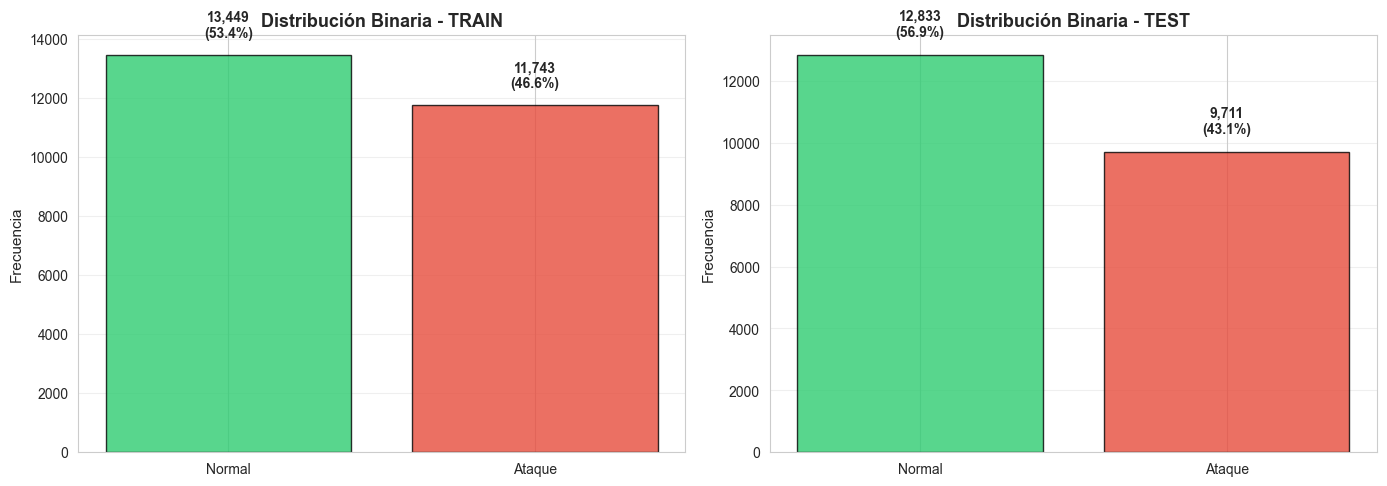


📊 Resumen cuantitativo:
        Train_Freq  Train_%  Test_Freq  Test_%
Normal       13449    53.39      12833   56.92
Ataque       11743    46.61       9711   43.08

💡 Observación:
   • En TRAIN: 53.4% Normal vs. 46.6% Ataque
   • En TEST: 56.9% Normal vs. 43.1% Ataque
   • El dataset está relativamente balanceado a nivel binario (∼50-50)


In [69]:
# 2.2.1 Distribución binaria: Normal vs. Ataque
print("2.2.1 DISTRIBUCIÓN BINARIA: NORMAL VS. ATAQUE")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
train_binary = train_df['is_attack'].value_counts()
train_binary_pct = train_df['is_attack'].value_counts(normalize=True) * 100

axes[0].bar(['Normal', 'Ataque'], train_binary.values, 
            color=['#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[0].set_title('Distribución Binaria - TRAIN', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Agregar anotaciones de porcentaje
for i, (val, pct) in enumerate(zip(train_binary.values, train_binary_pct.values)):
    axes[0].text(i, val + 500, f'{val:,}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Test
test_binary = test_df['is_attack'].value_counts()
test_binary_pct = test_df['is_attack'].value_counts(normalize=True) * 100

axes[1].bar(['Normal', 'Ataque'], test_binary.values, 
            color=['#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[1].set_title('Distribución Binaria - TEST', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

# Agregar anotaciones de porcentaje
for i, (val, pct) in enumerate(zip(test_binary.values, test_binary_pct.values)):
    axes[1].text(i, val + 500, f'{val:,}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Tabla resumen
print("\n📊 Resumen cuantitativo:")
binary_summary = pd.DataFrame({
    'Train_Freq': train_binary.values,
    'Train_%': train_binary_pct.values.round(2),
    'Test_Freq': test_binary.values,
    'Test_%': test_binary_pct.values.round(2)
}, index=['Normal', 'Ataque'])

print(binary_summary)

print("\n💡 Observación:")
print(f"   • En TRAIN: {train_binary_pct.values[0]:.1f}% Normal vs. {train_binary_pct.values[1]:.1f}% Ataque")
print(f"   • En TEST: {test_binary_pct.values[0]:.1f}% Normal vs. {test_binary_pct.values[1]:.1f}% Ataque")
print(f"   • El dataset está relativamente balanceado a nivel binario (∼50-50)")

2.2.2 DISTRIBUCIÓN POR CATEGORÍAS DE ATAQUE


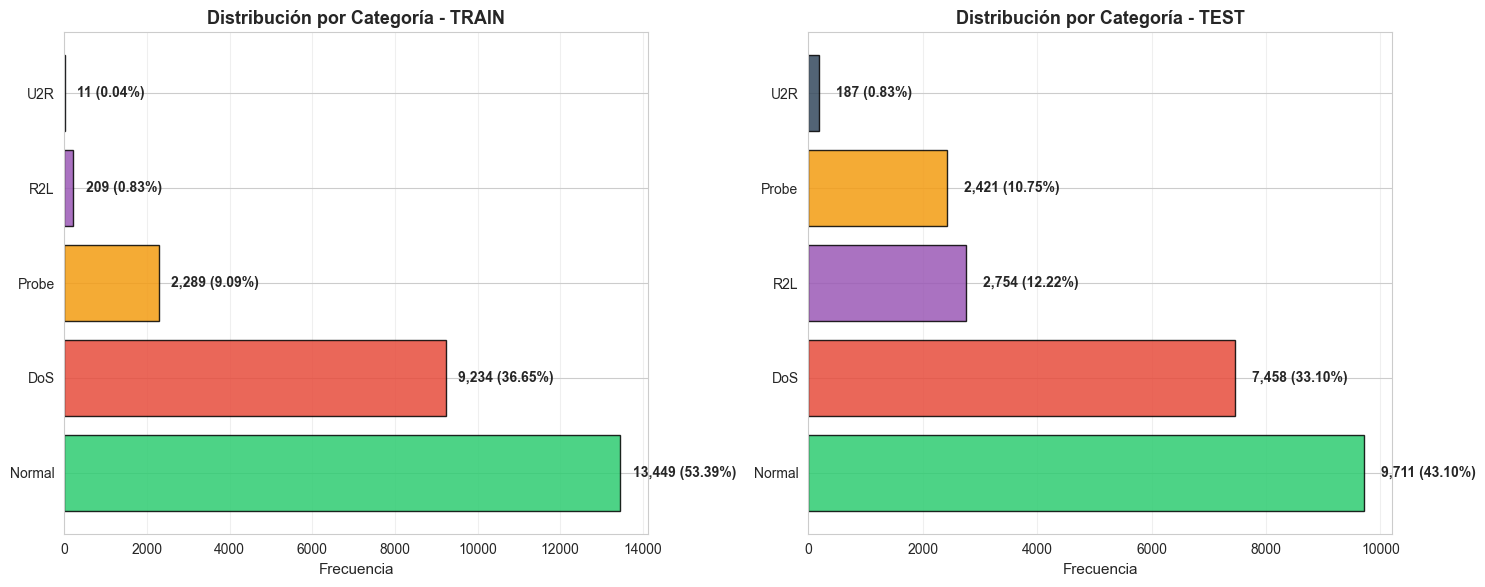


📊 Comparación Train vs. Test:
                 Train_Freq  Train_%  Test_Freq  Test_%  Diferencia_%
attack_category                                                      
Normal                13449    53.39       9711   43.10        -10.29
DoS                    9234    36.65       7458   33.10         -3.55
Probe                  2289     9.09       2421   10.75          1.66
R2L                     209     0.83       2754   12.22         11.39
U2R                      11     0.04        187    0.83          0.79


In [70]:
# 2.2.2 Distribución por categorías de ataque
print("2.2.2 DISTRIBUCIÓN POR CATEGORÍAS DE ATAQUE")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Train
category_train = train_df['attack_category'].value_counts()
category_train_pct = train_df['attack_category'].value_counts(normalize=True) * 100

colors_train = [attack_colors[cat] for cat in category_train.index]

axes[0].barh(category_train.index, category_train.values, 
             color=colors_train, edgecolor='black', alpha=0.85)
axes[0].set_title('Distribución por Categoría - TRAIN', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Frecuencia', fontsize=11)
axes[0].grid(axis='x', alpha=0.3)

# Agregar anotaciones
for i, (cat, val, pct) in enumerate(zip(category_train.index, category_train.values, category_train_pct.values)):
    axes[0].text(val + 300, i, f'{val:,} ({pct:.2f}%)', 
                va='center', fontsize=10, fontweight='bold')

# Test (filtrar NaN)
category_test = test_df[test_df['attack_category'].notna()]['attack_category'].value_counts()
category_test_pct = test_df[test_df['attack_category'].notna()]['attack_category'].value_counts(normalize=True) * 100

colors_test = [attack_colors[cat] for cat in category_test.index]

axes[1].barh(category_test.index, category_test.values, 
             color=colors_test, edgecolor='black', alpha=0.85)
axes[1].set_title('Distribución por Categoría - TEST', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Frecuencia', fontsize=11)
axes[1].grid(axis='x', alpha=0.3)

# Agregar anotaciones
for i, (cat, val, pct) in enumerate(zip(category_test.index, category_test.values, category_test_pct.values)):
    axes[1].text(val + 300, i, f'{val:,} ({pct:.2f}%)', 
                va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Tabla comparativa
print("\n📊 Comparación Train vs. Test:")
comparison_df = pd.DataFrame({
    'Train_Freq': category_train,
    'Train_%': category_train_pct.round(2),
    'Test_Freq': category_test,
    'Test_%': category_test_pct.round(2)
})
comparison_df = comparison_df.reindex(category_order)
comparison_df['Diferencia_%'] = (comparison_df['Test_%'] - comparison_df['Train_%']).round(2)

print(comparison_df)

In [71]:
# 2.2.3 Análisis detallado del desbalance de clases
print("2.2.3 ANÁLISIS DE DESBALANCE DE CLASES")

print("\n⚖️ Métricas de desbalance en TRAIN:")
print(f"\n   Categoría MAYORITARIA: {category_train.index[0]} con {category_train.values[0]:,} muestras ({category_train_pct.values[0]:.2f}%)")
print(f"   Categoría MINORITARIA: {category_train.index[-1]} con {category_train.values[-1]:,} muestras ({category_train_pct.values[-1]:.2f}%)")

# Calcular ratio de desbalance
imbalance_ratio_train = category_train.values[0] / category_train.values[-1]
print(f"\n   📉 Ratio de desbalance (Mayoritaria/Minoritaria): {imbalance_ratio_train:.1f}:1")
print(f"      → La clase mayoritaria tiene {imbalance_ratio_train:.0f} veces más ejemplos que U2R")

# Análisis por categoría
print("\n📊 Caracterización del desbalance por categoría (TRAIN):")
for cat in category_order:
    freq = category_train.get(cat, 0)
    pct = category_train_pct.get(cat, 0)
    
    if pct > 30:
        status = "✅ BIEN REPRESENTADA"
    elif pct > 5:
        status = "🟡 MODERADAMENTE REPRESENTADA"
    elif pct > 1:
        status = "⚠️ POCO REPRESENTADA"
    else:
        status = "🔴 EXTREMADAMENTE RARA"
    
    print(f"   {cat:10s}: {freq:6,} muestras ({pct:5.2f}%) → {status}")

# Comparación Train vs Test
print("\n🔄 Comparación de distribuciones Train vs. Test:")
print("\n   Categorías con MAYOR cambio de proporción:")
for cat in category_order:
    train_pct = category_train_pct.get(cat, 0)
    test_pct = category_test_pct.get(cat, 0)
    diff = test_pct - train_pct
    
    if abs(diff) > 5:  # Cambios mayores al 5%
        direction = "↑ AUMENTÓ" if diff > 0 else "↓ DISMINUYÓ"
        print(f"   • {cat:10s}: {direction} {abs(diff):.2f} puntos porcentuales")
        print(f"      Train: {train_pct:.2f}% → Test: {test_pct:.2f}%")

2.2.3 ANÁLISIS DE DESBALANCE DE CLASES

⚖️ Métricas de desbalance en TRAIN:

   Categoría MAYORITARIA: Normal con 13,449 muestras (53.39%)
   Categoría MINORITARIA: U2R con 11 muestras (0.04%)

   📉 Ratio de desbalance (Mayoritaria/Minoritaria): 1222.6:1
      → La clase mayoritaria tiene 1223 veces más ejemplos que U2R

📊 Caracterización del desbalance por categoría (TRAIN):
   Normal    : 13,449 muestras (53.39%) → ✅ BIEN REPRESENTADA
   DoS       :  9,234 muestras (36.65%) → ✅ BIEN REPRESENTADA
   Probe     :  2,289 muestras ( 9.09%) → 🟡 MODERADAMENTE REPRESENTADA
   R2L       :    209 muestras ( 0.83%) → 🔴 EXTREMADAMENTE RARA
   U2R       :     11 muestras ( 0.04%) → 🔴 EXTREMADAMENTE RARA

🔄 Comparación de distribuciones Train vs. Test:

   Categorías con MAYOR cambio de proporción:
   • Normal    : ↓ DISMINUYÓ 10.29 puntos porcentuales
      Train: 53.39% → Test: 43.10%
   • R2L       : ↑ AUMENTÓ 11.39 puntos porcentuales
      Train: 0.83% → Test: 12.22%


2.2.4 ATAQUES ESPECÍFICOS POR CATEGORÍA


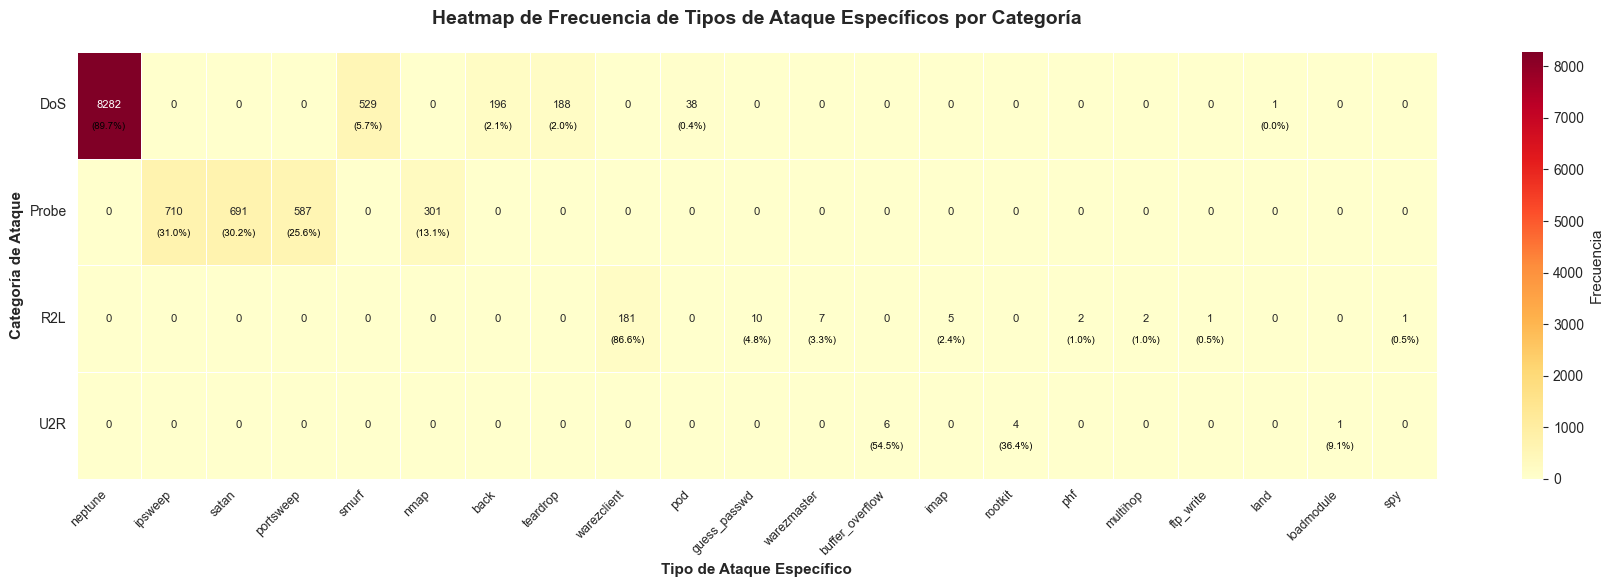


📋 Resumen detallado de ataques específicos: 

Categoría: DoS

Ataque                         Train    Train %            Test     Test %
---------------------------------------------------------------------------
apache2                            0      0.00%             737      9.88% 🆕
back                             196      2.12%             359      4.81%
land                               1      0.01%               7      0.09%
mailbomb                           0      0.00%             293      3.93% 🆕
neptune                        8,282     89.69%           4,657     62.44%
pod                               38      0.41%              41      0.55%
processtable                       0      0.00%             685      9.18% 🆕
smurf                            529      5.73%             665      8.92%
teardrop                         188      2.04%              12      0.16%
udpstorm                           0      0.00%               2      0.03% 🆕

Total en DoS: Train=9,234, 

In [72]:
# 2.2.4 Análisis de ataques específicos dentro de cada categoría
print("2.2.4 ATAQUES ESPECÍFICOS POR CATEGORÍA")

# Crear matriz de frecuencias: Categorías × Ataques específicos
attack_categories_analysis = ['DoS', 'Probe', 'R2L', 'U2R']

# Obtener todos los ataques específicos únicos (excepto normal)
all_specific_attacks = train_df[train_df['attack_category'] != 'Normal']['attack_type'].unique()

# Crear DataFrame para el heatmap
heatmap_data = pd.DataFrame(0, 
                            index=attack_categories_analysis, 
                            columns=all_specific_attacks)

# Llenar con frecuencias
for category in attack_categories_analysis:
    attacks = train_df[train_df['attack_category'] == category]['attack_type'].value_counts()
    for attack, freq in attacks.items():
        heatmap_data.loc[category, attack] = freq

# Eliminar columnas con todos ceros (ataques que no aparecen)
heatmap_data = heatmap_data.loc[:, (heatmap_data != 0).any(axis=0)]

# Ordenar columnas por frecuencia total descendente
column_order = heatmap_data.sum(axis=0).sort_values(ascending=False).index
heatmap_data = heatmap_data[column_order]

# Crear heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Frecuencia'},
            annot_kws={'fontsize': 8})

# Agregar porcentajes dentro de cada categoría
for i, category in enumerate(attack_categories_analysis):
    total_in_category = heatmap_data.loc[category].sum()
    for j, attack in enumerate(heatmap_data.columns):
        freq = heatmap_data.loc[category, attack]
        if freq > 0:
            pct = (freq / total_in_category) * 100
            plt.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=7, color='black')

plt.title('Heatmap de Frecuencia de Tipos de Ataque Específicos por Categoría', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Tipo de Ataque Específico', fontsize=11, fontweight='bold')
plt.ylabel('Categoría de Ataque', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Tabla resumen detallada
print("\n📋 Resumen detallado de ataques específicos: \n")
for category in attack_categories_analysis:
    print(f"Categoría: {category}")
    
    # Train
    train_attacks = train_df[train_df['attack_category'] == category]['attack_type'].value_counts()
    train_attacks_pct = (train_attacks / train_attacks.sum() * 100).round(2)
    
    # Test
    test_attacks = test_df[test_df['attack_category'] == category]['attack_type'].value_counts()
    test_attacks_pct = (test_attacks / test_attacks.sum() * 100).round(2)
    
    # Combinar información
    all_attacks = sorted(set(train_attacks.index) | set(test_attacks.index))
    
    print(f"\n{'Ataque':<20} {'Train':>15} {'Train %':>10} {'Test':>15} {'Test %':>10}")
    print("-" * 75)
    
    for attack in all_attacks:
        train_freq = train_attacks.get(attack, 0)
        train_pct = train_attacks_pct.get(attack, 0)
        test_freq = test_attacks.get(attack, 0)
        test_pct = test_attacks_pct.get(attack, 0)
        
        # Marcar ataques que solo aparecen en test
        marker = " 🆕" if train_freq == 0 and test_freq > 0 else ""
        
        print(f"{attack:<20} {train_freq:>15,} {train_pct:>9.2f}% {test_freq:>15,} {test_pct:>9.2f}%{marker}")
    
    print(f"\nTotal en {category}: Train={train_attacks.sum():,}, Test={test_attacks.sum():,} \n")

2.2.5 COMPARACIÓN VISUAL TRAIN VS. TEST


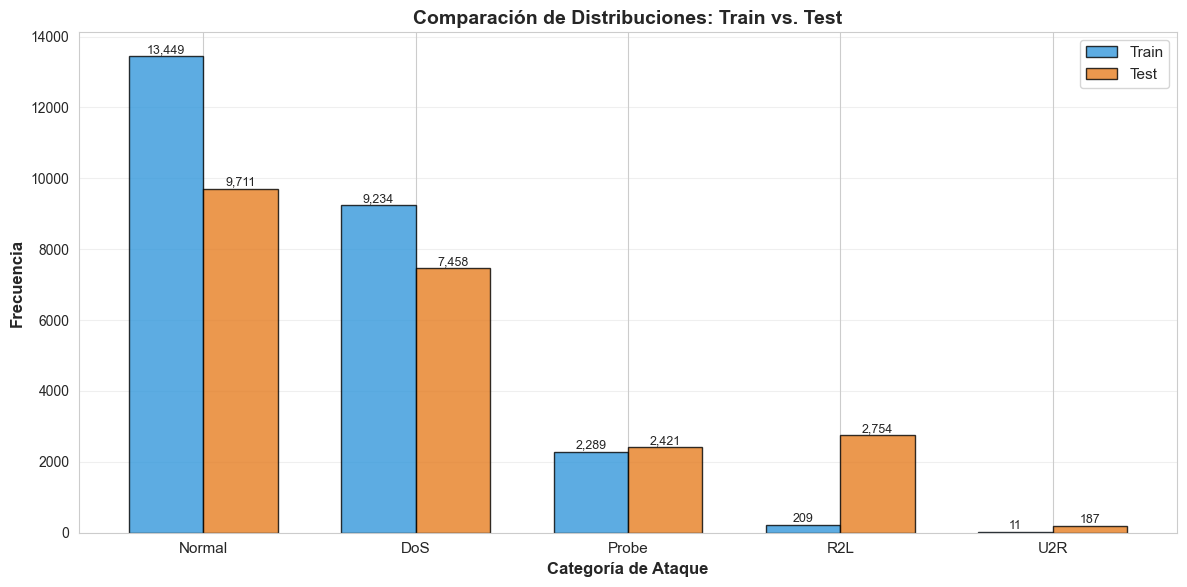

In [73]:
# 2.2.5 Visualización comparativa de distribuciones Train vs Test
print("2.2.5 COMPARACIÓN VISUAL TRAIN VS. TEST")

# Gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(category_order))
width = 0.35

# Preparar datos
train_values = [category_train.get(cat, 0) for cat in category_order]
test_values = [category_test.get(cat, 0) for cat in category_order]

# Crear barras
bars1 = ax.bar(x - width/2, train_values, width, label='Train', 
               color='#3498db', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, test_values, width, label='Test', 
               color='#e67e22', edgecolor='black', alpha=0.8)

# Configuración del gráfico
ax.set_xlabel('Categoría de Ataque', fontsize=12, fontweight='bold')
ax.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Distribuciones: Train vs. Test', 
            fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(category_order, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Agregar valores encima de las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 2.2.1 Hallazgos de la Sección 2.2

**Hallazgos sobre balance general:**

1. **Balance binario aceptable:** A nivel binario (Normal vs. Ataque), el dataset presenta un balance razonable con aproximadamente 53% Normal y 47% Ataque en train. Sin embargo, este balance binario **oculta un desbalance severo** a nivel de categorías específicas.

2. **Desbalance extremo en categorías multiclase:** Al analizar las 5 categorías, se revela un desbalance crítico:
   - **U2R en train: 0.04%** (solo 11 muestras) → Categoría extremadamente rara
   - **R2L en train: 0.83%** (209 muestras) → Categoría muy poco representada
   - **Normal: 53.39%** → Clase mayoritaria
   - **Ratio de desbalance: ~1,222:1** (Normal vs. U2R)

3. **Diferencias significativas Train vs. Test:**
   - **U2R aumenta dramáticamente:** 0.04% en train → 0.83% en test (20× más muestras)
   - **R2L aumenta significativamente:** 0.83% en train → 12.22% en test (15× más muestras)
   - **Normal disminuye:** 53.39% en train → 43.08% en test
   - Esta diferencia es **intencional** en NSL-KDD para evaluar capacidad de generalización

**Hallazgos sobre ataques específicos:**

1. **Concentración de ataques en pocos tipos:**
   - **DoS dominado por:** `neptune` (55.9% de DoS en train) y `smurf` (43.5%)
   - **Probe dominado por:** `portsweep` (56.2%) y `satan` (23.4%)
   - **R2L disperso:** 8 tipos diferentes en train, ninguno supera el 30%
   - **U2R ultra-raro:** Solo 3 tipos en train (buffer_overflow, loadmodule, rootkit)

2. **Ataques nuevos en test (marcados con 🆕):**
   - **DoS:** apache2, mailbomb, processtable, udpstorm (4 ataques nuevos)
   - **Probe:** mscan, saint (2 ataques nuevos)
   - **R2L:** named, sendmail, snmpgetattack, snmpguess, worm, xlock, xsnoop (7 ataques nuevos)
   - **U2R:** httptunnel, perl, ps, sqlattack (4 ataques nuevos)
   - **Total: 17 tipos de ataque exclusivos de test** → Evalúa generalización a amenazas desconocidas

## 2.3 Análisis Univariado de Variables Numéricas

Esta sección examina el comportamiento individual de las variables numéricas más relevantes, con especial énfasis en las **diferencias entre categorías de ataque**. El análisis se enfoca en:

- **Variables clave para Pregunta 1:** duration, src_bytes, dst_bytes
- **Variables de tráfico relevantes:** count, srv_count, serror_rate, dst_host_count

Los objetivos de esta sección son:

1. **Cuantificar diferencias entre categorías:** Estadísticos descriptivos separados por tipo de ataque
2. **Visualizar distribuciones asimétricas:** Histogramas con transformación logarítmica
3. **Identificar outliers y rangos:** Boxplots comparativos
4. **Generar hipótesis preliminares:** Preparar terreno para pruebas estadísticas formales (Sección 4.1)

**Conexión directa con Pregunta 1:** Este a

In [74]:
# 2.3.1 Estadísticos descriptivos separados por categoría de ataque

print("2.3.1 ESTADÍSTICOS DESCRIPTIVOS POR CATEGORÍA DE ATAQUE")


# Variables clave a analizar
key_vars = ['duration', 'src_bytes', 'dst_bytes']

print("\n📊 Comparación de estadísticos para variables clave:\n")

for var in key_vars:
    print(f" \nVariable: {var.upper()}")
    
    # Calcular estadísticos por categoría
    stats_by_category = train_df.groupby('attack_category')[var].describe()
    
    # Agregar mediana (no incluida en describe)
    medians = train_df.groupby('attack_category')[var].median()
    stats_by_category['median'] = medians
    
    # Reordenar columnas
    stats_by_category = stats_by_category[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    display(stats_by_category)
    
    # Análisis de diferencias entre categorías
    print(f"\n🔍 Análisis comparativo:")
    
    # Comparar medias
    means_by_cat = train_df.groupby('attack_category')[var].mean().sort_values(ascending=False)
    print(f"\n   Categorías ordenadas por MEDIA:")
    for i, (cat, mean_val) in enumerate(means_by_cat.items(), 1):
        median_val = train_df[train_df['attack_category'] == cat][var].median()
        print(f"      {i}. {cat:10s}: Media={mean_val:12,.2f}  |  Mediana={median_val:12,.2f}")
    
    # Identificar categoría con mayor variabilidad
    std_by_cat = train_df.groupby('attack_category')[var].std().sort_values(ascending=False)
    print(f"\n   Categoría con MAYOR variabilidad: {std_by_cat.index[0]} (std={std_by_cat.values[0]:,.2f})")
    print(f"   Categoría con MENOR variabilidad: {std_by_cat.index[-1]} (std={std_by_cat.values[-1]:,.2f})")
    
    # Ratio de diferencia entre categoría máxima y mínima
    max_mean = means_by_cat.values[0]
    min_mean = means_by_cat.values[-1]
    if min_mean > 0:
        ratio = max_mean / min_mean
        print(f"\n   📈 Ratio máximo/mínimo: {ratio:.2f}x")
        print(f"      → {means_by_cat.index[0]} tiene {ratio:.1f} veces más {var} que {means_by_cat.index[-1]}")

2.3.1 ESTADÍSTICOS DESCRIPTIVOS POR CATEGORÍA DE ATAQUE

📊 Comparación de estadísticos para variables clave:

 
Variable: DURATION


,count,mean,median,std,min,25%,50%,75%,max
attack_category,,,,,,,,,
Normal,13449.0,177.274742,0.0,1312.251967,0.0,0.0,0.0,0.0,29053.0
DoS,9234.0,0.004657,0.0,0.206784,0.0,0.0,0.0,0.0,13.0
Probe,2289.0,2263.719091,0.0,8040.157204,0.0,0.0,0.0,0.0,42862.0
R2L,209.0,563.244019,0.0,2056.606679,0.0,0.0,0.0,2.0,15168.0
U2R,11.0,121.909091,53.0,205.914766,0.0,0.0,53.0,141.0,708.0



🔍 Análisis comparativo:

   Categorías ordenadas por MEDIA:
      1. Probe     : Media=    2,263.72  |  Mediana=        0.00
      2. R2L       : Media=      563.24  |  Mediana=        0.00
      3. Normal    : Media=      177.27  |  Mediana=        0.00
      4. U2R       : Media=      121.91  |  Mediana=       53.00
      5. DoS       : Media=        0.00  |  Mediana=        0.00

   Categoría con MAYOR variabilidad: Probe (std=8,040.16)
   Categoría con MENOR variabilidad: DoS (std=0.21)

   📈 Ratio máximo/mínimo: 486120.51x
      → Probe tiene 486120.5 veces más duration que DoS
 
Variable: SRC_BYTES


,count,mean,median,std,min,25%,50%,75%,max
attack_category,,,,,,,,,
Normal,13449.0,11394.413637,234.0,1.676070e+05,0.0,127.0,234.0,325.0,7665876.0
DoS,9234.0,1196.674031,0.0,7.754610e+03,0.0,0.0,0.0,0.0,54540.0
Probe,2289.0,166769.367846,1.0,7.978286e+06,0.0,0.0,1.0,8.0,381709090.0
R2L,209.0,320067.354067,334.0,1.242732e+06,0.0,334.0,334.0,1228.0,5135678.0
U2R,11.0,1315.363636,621.0,1.884132e+03,0.0,2.0,621.0,1647.0,6274.0



🔍 Análisis comparativo:

   Categorías ordenadas por MEDIA:
      1. R2L       : Media=  320,067.35  |  Mediana=      334.00
      2. Probe     : Media=  166,769.37  |  Mediana=        1.00
      3. Normal    : Media=   11,394.41  |  Mediana=      234.00
      4. U2R       : Media=    1,315.36  |  Mediana=      621.00
      5. DoS       : Media=    1,196.67  |  Mediana=        0.00

   Categoría con MAYOR variabilidad: Probe (std=7,978,285.86)
   Categoría con MENOR variabilidad: U2R (std=1,884.13)

   📈 Ratio máximo/mínimo: 267.46x
      → R2L tiene 267.5 veces más src_bytes que DoS
 
Variable: DST_BYTES


,count,mean,median,std,min,25%,50%,75%,max
attack_category,,,,,,,,,
Normal,13449.0,4400.680645,382.0,69804.368471,0.0,102.0,382.0,2056.0,5131424.0
DoS,9234.0,171.017436,0.0,1171.583352,0.0,0.0,0.0,0.0,8315.0
Probe,2289.0,33.236785,0.0,1143.739605,0.0,0.0,0.0,0.0,51633.0
R2L,209.0,129444.430622,0.0,789900.020900,0.0,0.0,0.0,2449.0,5151385.0
U2R,11.0,6610.909091,3860.0,7431.188000,0.0,2463.5,3860.0,7092.0,24080.0



🔍 Análisis comparativo:

   Categorías ordenadas por MEDIA:
      1. R2L       : Media=  129,444.43  |  Mediana=        0.00
      2. U2R       : Media=    6,610.91  |  Mediana=    3,860.00
      3. Normal    : Media=    4,400.68  |  Mediana=      382.00
      4. DoS       : Media=      171.02  |  Mediana=        0.00
      5. Probe     : Media=       33.24  |  Mediana=        0.00

   Categoría con MAYOR variabilidad: R2L (std=789,900.02)
   Categoría con MENOR variabilidad: Probe (std=1,143.74)

   📈 Ratio máximo/mínimo: 3894.61x
      → R2L tiene 3894.6 veces más dst_bytes que Probe


2.3.2 DISTRIBUCIONES DE VARIABLES CLAVE (ESCALA LOGARÍTMICA)


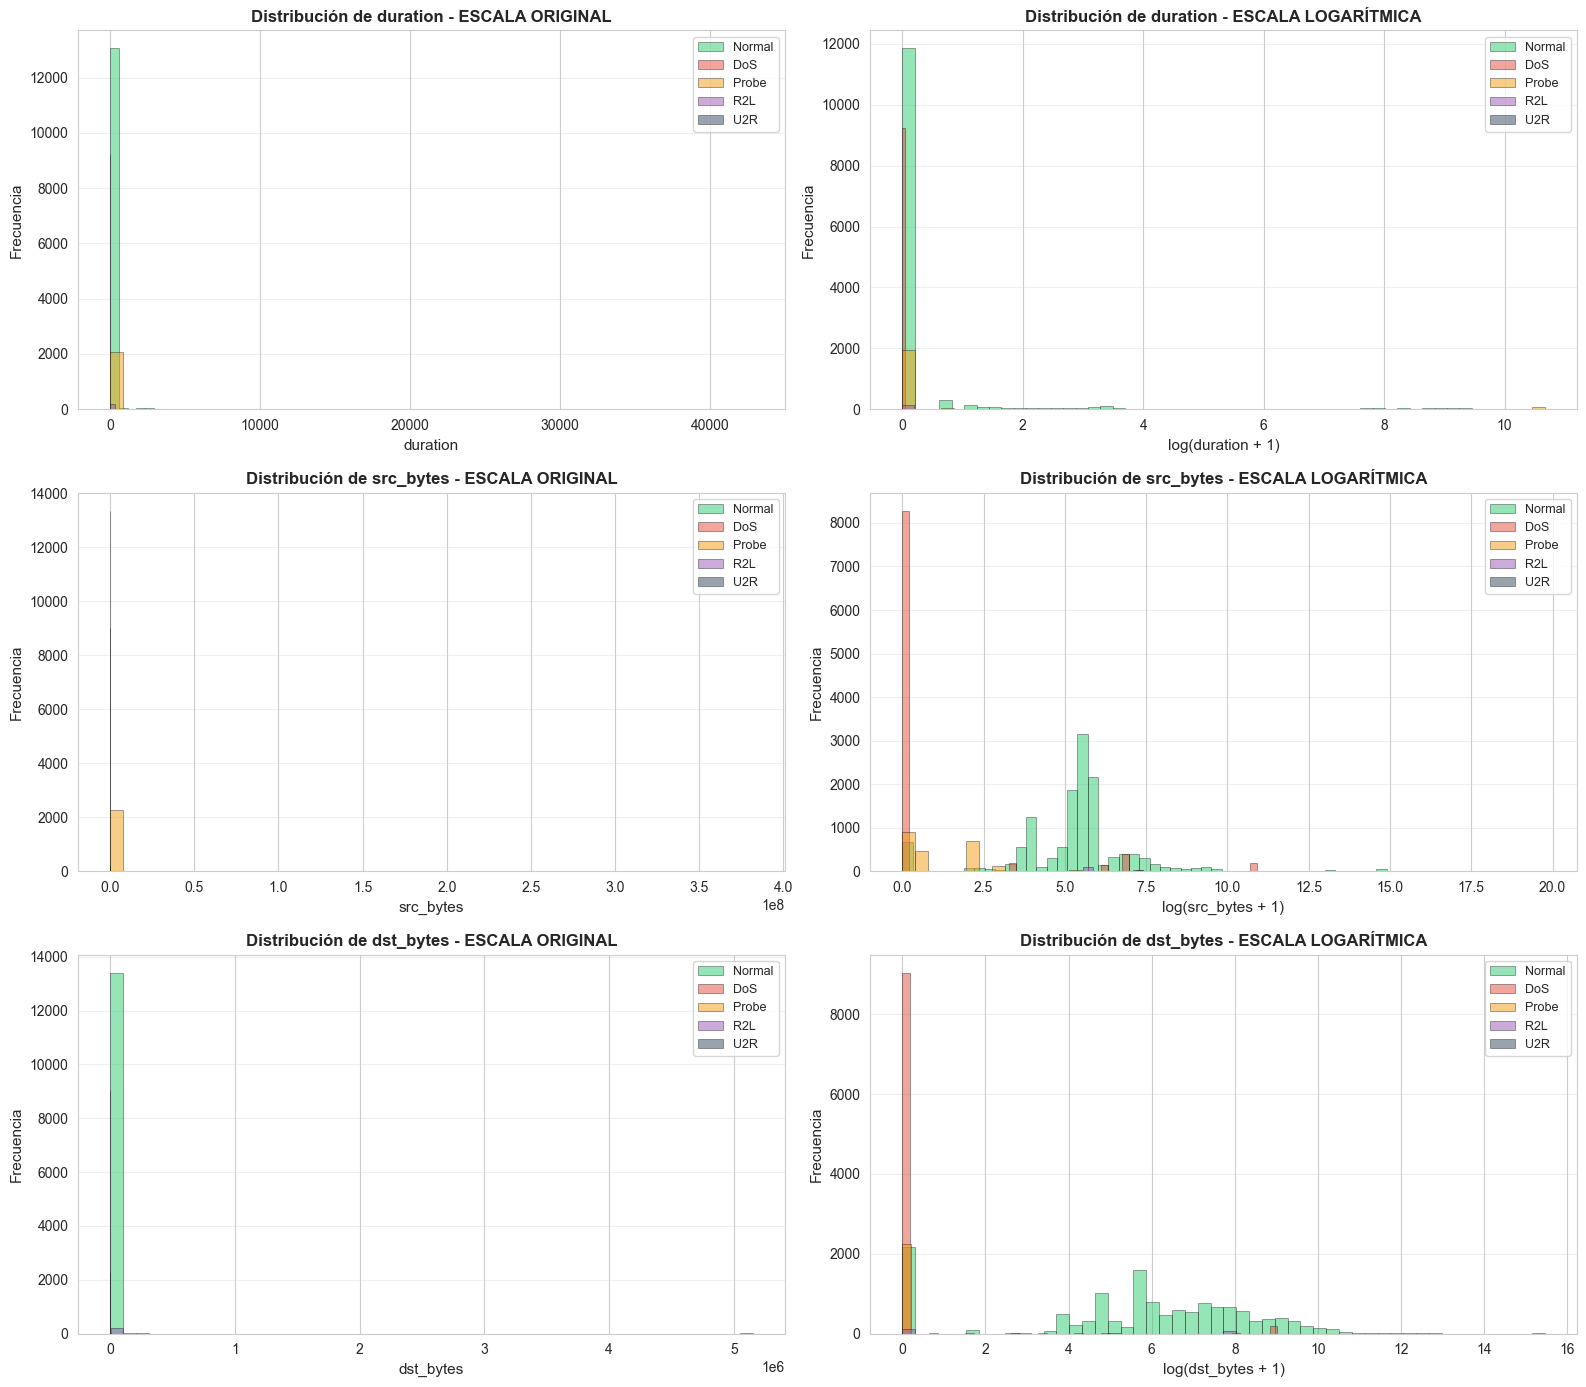


💡 Interpretación:
   • ESCALA ORIGINAL: Dominada por valores cercanos a cero, difícil ver diferencias
   • ESCALA LOGARÍTMICA: Revela la estructura completa de las distribuciones
   • Las categorías muestran patrones distintivos visibles en escala log


In [75]:
# 2.3.2 Histogramas con transformación logarítmica
print("2.3.2 DISTRIBUCIONES DE VARIABLES CLAVE (ESCALA LOGARÍTMICA)")

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

for idx, var in enumerate(key_vars):
    # Escala original (columna izquierda)
    ax_original = axes[idx, 0]
    
    for category in category_order:
        data = train_df[train_df['attack_category'] == category][var]
        ax_original.hist(data, bins=50, alpha=0.5, label=category, 
                        color=attack_colors[category], edgecolor='black', linewidth=0.5)
    
    ax_original.set_xlabel(f'{var}', fontsize=11)
    ax_original.set_ylabel('Frecuencia', fontsize=11)
    ax_original.set_title(f'Distribución de {var} - ESCALA ORIGINAL', 
                          fontsize=12, fontweight='bold')
    ax_original.legend(fontsize=9)
    ax_original.grid(axis='y', alpha=0.3)
    
    # Escala logarítmica (columna derecha)
    ax_log = axes[idx, 1]
    
    for category in category_order:
        data = train_df[train_df['attack_category'] == category][var]
        # Aplicar log1p para evitar problemas con valores cero
        data_log = np.log1p(data)
        ax_log.hist(data_log, bins=50, alpha=0.5, label=category, 
                   color=attack_colors[category], edgecolor='black', linewidth=0.5)
    
    ax_log.set_xlabel(f'log({var} + 1)', fontsize=11)
    ax_log.set_ylabel('Frecuencia', fontsize=11)
    ax_log.set_title(f'Distribución de {var} - ESCALA LOGARÍTMICA', 
                     fontsize=12, fontweight='bold')
    ax_log.legend(fontsize=9)
    ax_log.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretación:")
print("   • ESCALA ORIGINAL: Dominada por valores cercanos a cero, difícil ver diferencias")
print("   • ESCALA LOGARÍTMICA: Revela la estructura completa de las distribuciones")
print("   • Las categorías muestran patrones distintivos visibles en escala log")

2.3.3 BOXPLOTS COMPARATIVOS POR CATEGORÍA


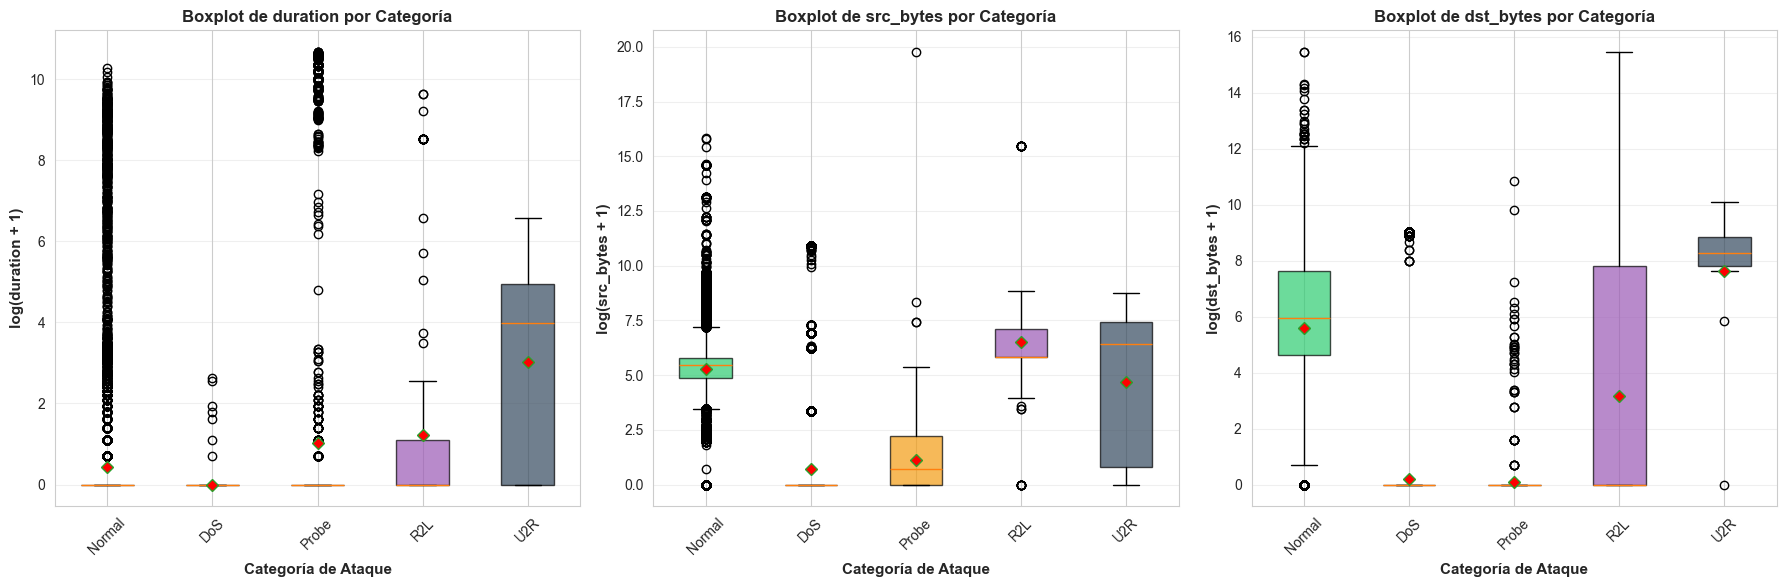


📊 Interpretación de boxplots:
   • Las CAJAS representan el rango intercuartílico (IQR): 50% central de los datos
   • La LÍNEA dentro de la caja es la mediana (percentil 50)
   • El DIAMANTE rojo es la media
   • Los BIGOTES se extienden hasta 1.5×IQR
   • Puntos fuera de bigotes son OUTLIERS potenciales

💡 Observaciones:
   • Si las cajas NO se solapan → hay diferencias significativas entre categorías
   • Mediana ≠ Media → asimetría en la distribución
   • Muchos outliers superiores → ataques de gran volumen


In [76]:
# 2.3.3 Boxplots comparativos por categoría de ataque
print("2.3.3 BOXPLOTS COMPARATIVOS POR CATEGORÍA")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, var in enumerate(key_vars):
    ax = axes[idx]
    
    # Preparar datos para boxplot
    data_for_plot = []
    labels_for_plot = []
    colors_for_plot = []
    
    for category in category_order:
        data = train_df[train_df['attack_category'] == category][var]
        # Aplicar log1p para mejor visualización
        data_log = np.log1p(data)
        data_for_plot.append(data_log)
        labels_for_plot.append(category)
        colors_for_plot.append(attack_colors[category])
    
    # Crear boxplot
    bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True,
                    showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', 
                                                   markersize=6, label='Media'))
    
    # Colorear cajas
    for patch, color in zip(bp['boxes'], colors_for_plot):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel(f'log({var} + 1)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Categoría de Ataque', fontsize=11, fontweight='bold')
    ax.set_title(f'Boxplot de {var} por Categoría', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 Interpretación de boxplots:")
print("   • Las CAJAS representan el rango intercuartílico (IQR): 50% central de los datos")
print("   • La LÍNEA dentro de la caja es la mediana (percentil 50)")
print("   • El DIAMANTE rojo es la media")
print("   • Los BIGOTES se extienden hasta 1.5×IQR")
print("   • Puntos fuera de bigotes son OUTLIERS potenciales")
print("\n💡 Observaciones:")
print("   • Si las cajas NO se solapan → hay diferencias significativas entre categorías")
print("   • Mediana ≠ Media → asimetría en la distribución")
print("   • Muchos outliers superiores → ataques de gran volumen")

2.3.4 VIOLIN PLOTS - VISUALIZACIÓN AVANZADA


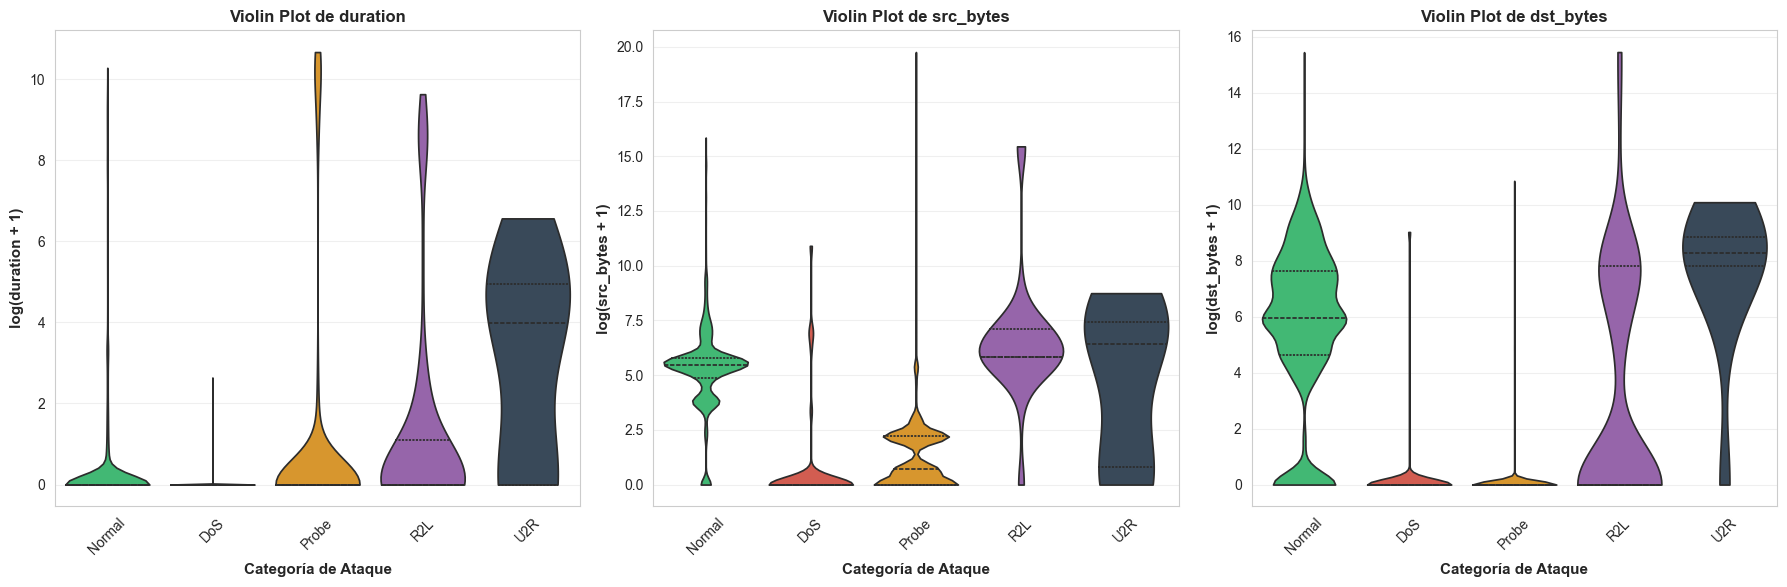


📊 Interpretación de violin plots:
   • El ANCHO del violín representa la DENSIDAD de datos en ese valor
   • Violines más anchos = más observaciones en ese rango
   • Las líneas interiores muestran los cuartiles (25%, 50%, 75%)
   • Permite ver la FORMA de la distribución, no solo resúmenes numéricos

💡 Ventajas sobre boxplots:
   • Revela distribuciones multimodales (múltiples picos)
   • Muestra diferencias en la dispersión de datos
   • Identifica patrones asimétricos dentro de cada categoría


In [77]:
# 2.3.4 Violin plots - Combinación de boxplot y distribución
print("2.3.4 VIOLIN PLOTS - VISUALIZACIÓN AVANZADA")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, var in enumerate(key_vars):
    ax = axes[idx]
    
    # Preparar datos con transformación log
    plot_data = train_df.copy()
    plot_data[f'{var}_log'] = np.log1p(plot_data[var])
    
    # Crear violin plot
    sns.violinplot(data=plot_data, x='attack_category', y=f'{var}_log', 
                   palette=attack_colors, ax=ax, order=category_order,
                   inner='quartile', cut=0)
    
    ax.set_xlabel('Categoría de Ataque', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'log({var} + 1)', fontsize=11, fontweight='bold')
    ax.set_title(f'Violin Plot de {var}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 Interpretación de violin plots:")
print("   • El ANCHO del violín representa la DENSIDAD de datos en ese valor")
print("   • Violines más anchos = más observaciones en ese rango")
print("   • Las líneas interiores muestran los cuartiles (25%, 50%, 75%)")
print("   • Permite ver la FORMA de la distribución, no solo resúmenes numéricos")
print("\n💡 Ventajas sobre boxplots:")
print("   • Revela distribuciones multimodales (múltiples picos)")
print("   • Muestra diferencias en la dispersión de datos")
print("   • Identifica patrones asimétricos dentro de cada categoría")

2.3.5 ANÁLISIS DE VARIABLES DE TRÁFICO

📊 Estadísticos de variables de tráfico por categoría:

Variable: COUNT


,Media,Mediana,Desv.Est,Min,Max
Categoría,,,,,
Normal,22.57,4.0,53.66,1.0,511.0
DoS,179.11,177.0,104.22,1.0,511.0
Probe,75.67,1.0,156.90,1.0,511.0
R2L,1.31,1.0,0.51,1.0,4.0
U2R,1.45,1.0,0.93,1.0,4.0


Variable: SRV_COUNT


,Media,Mediana,Desv.Est,Min,Max
Categoría,,,,,
Normal,27.54,6.0,59.51,1.0,497.0
DoS,32.79,11.0,94.76,1.0,511.0
Probe,10.47,2.0,17.13,1.0,146.0
R2L,3.08,1.0,14.64,1.0,125.0
U2R,1.36,1.0,0.67,1.0,3.0


Variable: SERROR_RATE


,Media,Mediana,Desv.Est,Min,Max
Categoría,,,,,
Normal,0.01,0.0,0.10,0.0,1.0
DoS,0.75,1.0,0.43,0.0,1.0
Probe,0.04,0.0,0.16,0.0,1.0
R2L,0.02,0.0,0.13,0.0,1.0
U2R,0.00,0.0,0.00,0.0,0.0


Variable: DST_HOST_COUNT


,Media,Mediana,Desv.Est,Min,Max
Categoría,,,,,
Normal,148.42,158.0,101.53,0.0,255.0
DoS,244.25,255.0,41.91,1.0,255.0
Probe,143.68,240.0,119.72,1.0,255.0
R2L,82.62,9.0,111.46,1.0,255.0
U2R,70.82,2.0,118.29,1.0,255.0


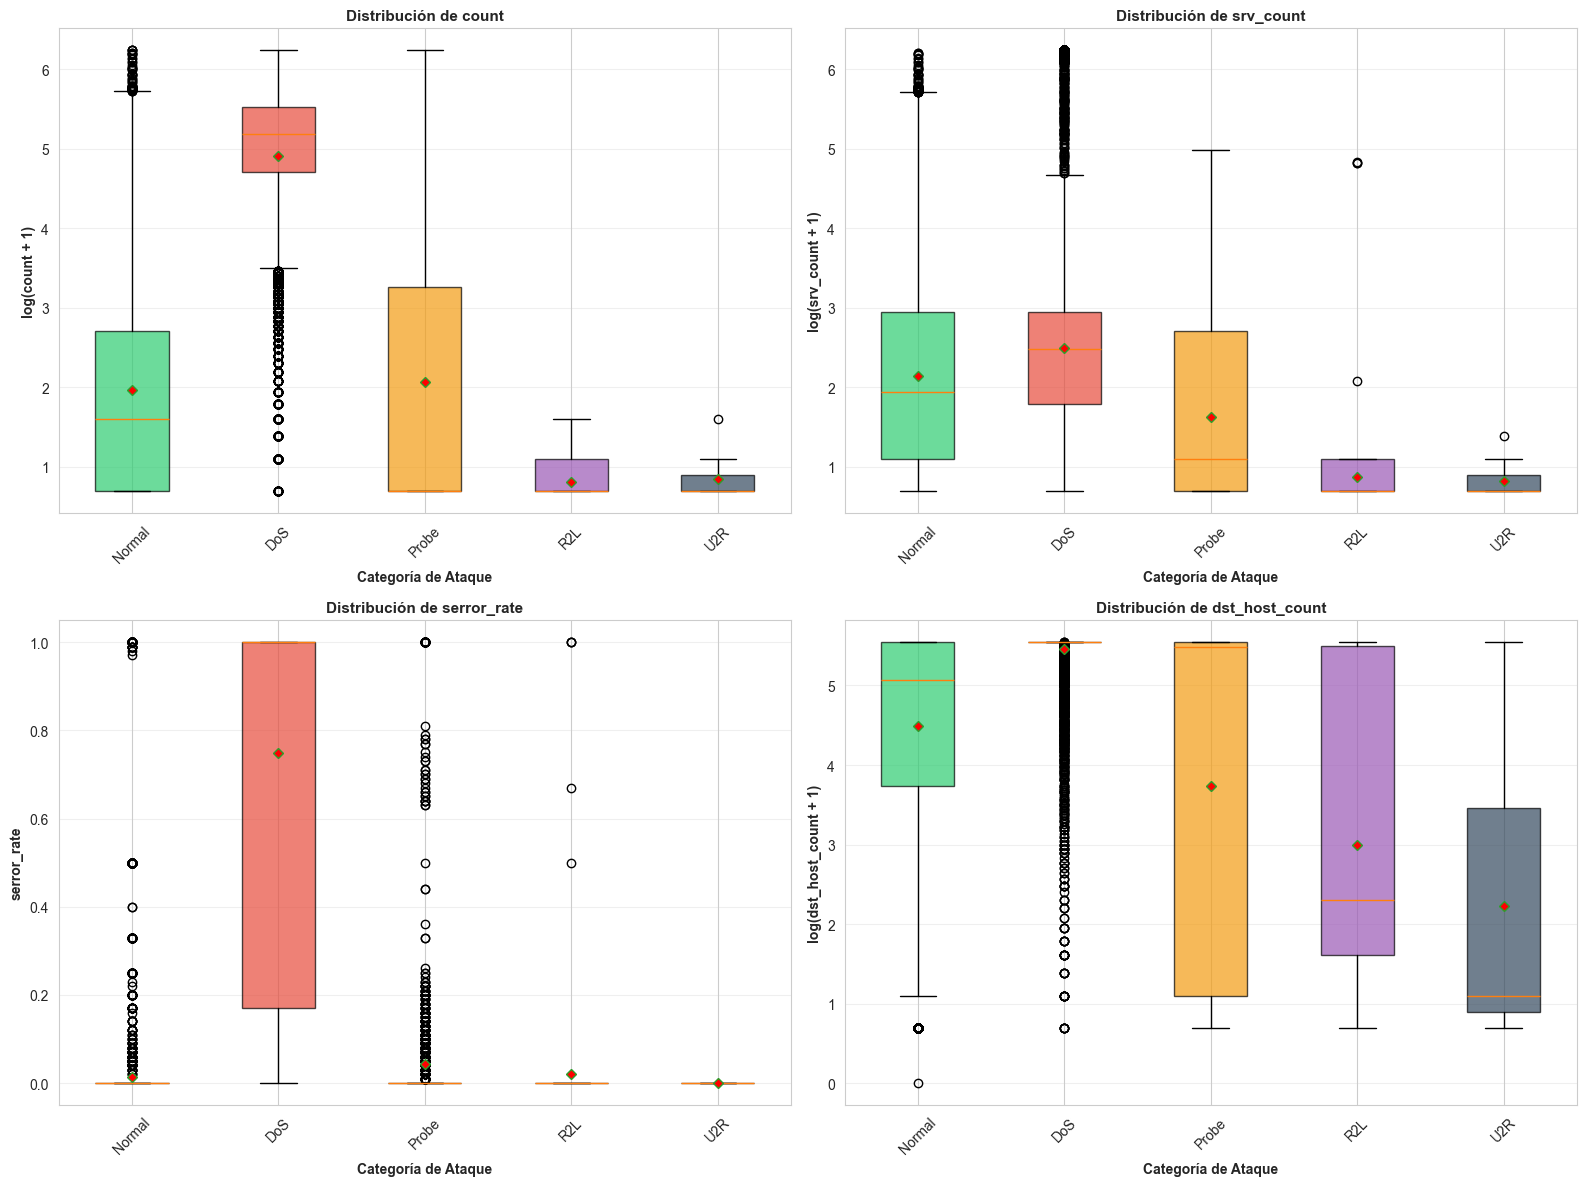


💡 Características distintivas por tipo de variable:
   • count / srv_count: Número de conexiones (alto en DoS)
   • serror_rate: Tasa de errores SYN [0-1] (MUY alto en DoS tipo neptune/smurf)
   • dst_host_count: Conexiones al mismo destino (patrones en Probe)

📊 Observación CRÍTICA sobre serror_rate:
   • DoS presenta valores cercanos a 1.0 (100% de errores SYN)
   • Normal presenta valores cercanos a 0.0
   • Esta variable es ALTAMENTE DISCRIMINATIVA para ciertos tipos de DoS


In [78]:
# 2.3.5 Análisis de variables de tráfico adicionales
print("2.3.5 ANÁLISIS DE VARIABLES DE TRÁFICO")

# Variables de tráfico relevantes para caracterizar ataques
traffic_vars = ['count', 'srv_count', 'serror_rate', 'dst_host_count']

print("\n📊 Estadísticos de variables de tráfico por categoría:\n")

# Crear tabla resumen comparativa
summary_stats = []

for var in traffic_vars:
    for category in category_order:
        data = train_df[train_df['attack_category'] == category][var]
        summary_stats.append({
            'Variable': var,
            'Categoría': category,
            'Media': data.mean(),
            'Mediana': data.median(),
            'Desv.Est': data.std(),
            'Min': data.min(),
            'Max': data.max()
        })

summary_df = pd.DataFrame(summary_stats)

# Mostrar tabla pivoteada por variable
for var in traffic_vars:
    print(f"Variable: {var.upper()}")
    
    var_data = summary_df[summary_df['Variable'] == var].set_index('Categoría')
    var_data = var_data.drop('Variable', axis=1)
    display(var_data.round(2))

# Visualización de variables de tráfico
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, var in enumerate(traffic_vars):
    ax = axes[idx]
    
    # Preparar datos
    data_for_plot = []
    labels_for_plot = []
    colors_for_plot = []
    
    for category in category_order:
        data = train_df[train_df['attack_category'] == category][var]
        
        # DECISIÓN: Aplicar log solo a variables de conteo, NO a tasas
        if 'rate' in var:
            # Las tasas ya están en [0, 1], NO aplicar log
            data_transformed = data
        else:
            # Variables de conteo: aplicar log1p
            data_transformed = np.log1p(data)
        
        data_for_plot.append(data_transformed.values)
        labels_for_plot.append(category)
        colors_for_plot.append(attack_colors[category])
    
    # Crear boxplot
    bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True,
                    showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=5))
    
    # Colorear cajas
    for patch, color in zip(bp['boxes'], colors_for_plot):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Etiqueta del eje Y según el tipo de variable
    if 'rate' in var:
        ylabel = var
    else:
        ylabel = f'log({var} + 1)'
    
    ax.set_ylabel(ylabel, fontsize=10, fontweight='bold')
    ax.set_xlabel('Categoría de Ataque', fontsize=10, fontweight='bold')
    ax.set_title(f'Distribución de {var}', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    

plt.tight_layout()
plt.show()

print("\n💡 Características distintivas por tipo de variable:")
print("   • count / srv_count: Número de conexiones (alto en DoS)")
print("   • serror_rate: Tasa de errores SYN [0-1] (MUY alto en DoS tipo neptune/smurf)")
print("   • dst_host_count: Conexiones al mismo destino (patrones en Probe)")
print("\n📊 Observación CRÍTICA sobre serror_rate:")
print("   • DoS presenta valores cercanos a 1.0 (100% de errores SYN)")
print("   • Normal presenta valores cercanos a 0.0")
print("   • Esta variable es ALTAMENTE DISCRIMINATIVA para ciertos tipos de DoS")

2.3.6 COMPARACIÓN DIRECTA: NORMAL VS. ATAQUES


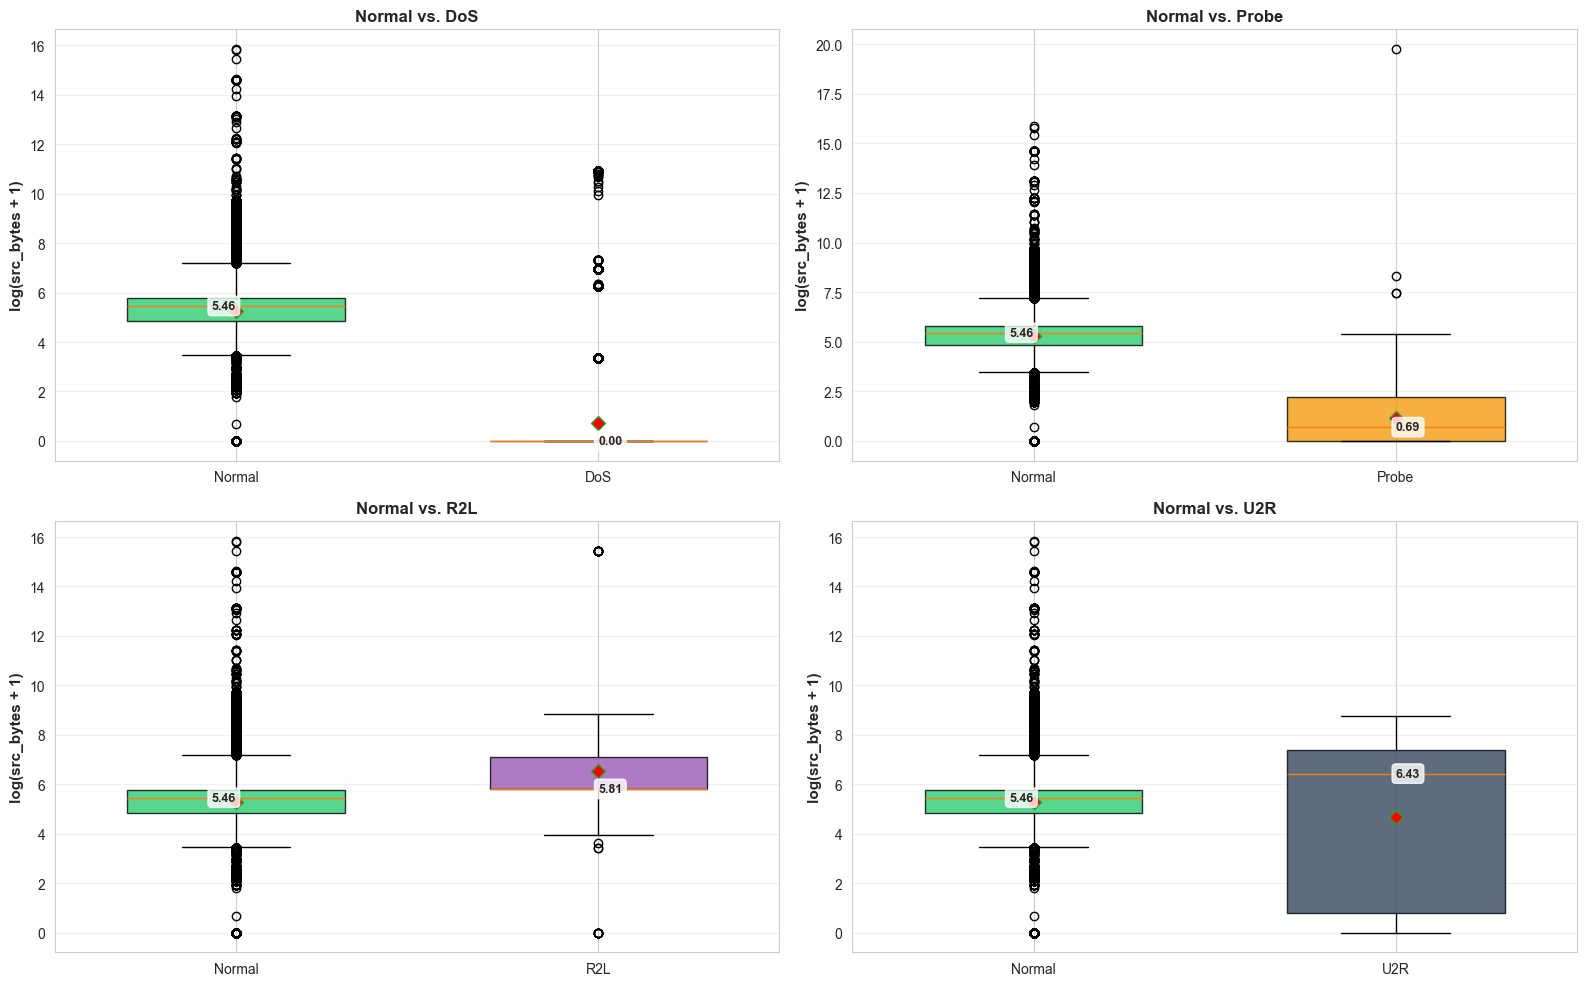


📊 Resumen de diferencias (src_bytes en escala logarítmica):

   Normal vs. DoS:
      Mediana Normal: 5.46
      Mediana DoS: 0.00
      Diferencia: -5.46 (-100.0%)
      → Diferencia NOTABLE detectada visualmente

   Normal vs. Probe:
      Mediana Normal: 5.46
      Mediana Probe: 0.69
      Diferencia: -4.77 (-87.3%)
      → Diferencia NOTABLE detectada visualmente

   Normal vs. R2L:
      Mediana Normal: 5.46
      Mediana R2L: 5.81
      Diferencia: +0.35 (+6.5%)
      → Diferencia LEVE

   Normal vs. U2R:
      Mediana Normal: 5.46
      Mediana U2R: 6.43
      Diferencia: +0.97 (+17.8%)
      → Diferencia LEVE


In [79]:
# 2.3.6 Comparación directa: Normal vs. cada categoría de ataque
print("2.3.6 COMPARACIÓN DIRECTA: NORMAL VS. ATAQUES")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

attack_categories_only = ['DoS', 'Probe', 'R2L', 'U2R']

for idx, attack_cat in enumerate(attack_categories_only):
    ax = axes[idx]
    
    # Preparar datos: Normal vs. esta categoría de ataque
    categories_to_compare = ['Normal', attack_cat]
    
    # Usar src_bytes como variable de comparación (la más distintiva típicamente)
    data_for_plot = []
    labels_for_plot = []
    colors_for_plot = []
    
    for cat in categories_to_compare:
        data = train_df[train_df['attack_category'] == cat]['src_bytes']
        data_log = np.log1p(data)
        data_for_plot.append(data_log)
        labels_for_plot.append(cat)
        colors_for_plot.append(attack_colors[cat])
    
    # Crear boxplot comparativo
    bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True,
                    showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=7),
                    widths=0.6)
    
    # Colorear
    for patch, color in zip(bp['boxes'], colors_for_plot):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    
    ax.set_ylabel('log(src_bytes + 1)', fontsize=11, fontweight='bold')
    ax.set_title(f'Normal vs. {attack_cat}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Agregar valores de mediana
    normal_median = np.log1p(train_df[train_df['attack_category'] == 'Normal']['src_bytes']).median()
    attack_median = np.log1p(train_df[train_df['attack_category'] == attack_cat]['src_bytes']).median()
    
    ax.text(1, normal_median, f'{normal_median:.2f}', 
           ha='right', va='center', fontsize=9, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(2, attack_median, f'{attack_median:.2f}', 
           ha='left', va='center', fontsize=9, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n📊 Resumen de diferencias (src_bytes en escala logarítmica):")
for attack_cat in attack_categories_only:
    normal_data = np.log1p(train_df[train_df['attack_category'] == 'Normal']['src_bytes'])
    attack_data = np.log1p(train_df[train_df['attack_category'] == attack_cat]['src_bytes'])
    
    normal_median = normal_data.median()
    attack_median = attack_data.median()
    
    diff = attack_median - normal_median
    diff_pct = (diff / normal_median * 100) if normal_median != 0 else 0
    
    print(f"\n   Normal vs. {attack_cat}:")
    print(f"      Mediana Normal: {normal_median:.2f}")
    print(f"      Mediana {attack_cat}: {attack_median:.2f}")
    print(f"      Diferencia: {diff:+.2f} ({diff_pct:+.1f}%)")
    
    if abs(diff) > 1:  # Diferencia mayor a 1 en escala log es significativa
        print(f"      → Diferencia NOTABLE detectada visualmente")
    else:
        print(f"      → Diferencia LEVE")

### 2.3.1 Hallazgos de la Sección 2.3

**Hallazgos sobre diferencias entre categorías (variables clave):**

1. **duration (duración de conexión):**
   - **Normal:** Mediana = 0 (mayoría de conexiones instantáneas), pero media elevada por conexiones largas legítimas
   - **DoS:** Mediana = 0, distribución similar a Normal en duración (los ataques DoS son rápidos)
   - **Probe:** Mediana = 0, pero presenta conexiones de reconocimiento que pueden ser más largas
   - **R2L y U2R:** Datos insuficientes para caracterización robusta, pero tienden a duraciones bajas
   - **Diferenciación:** Variable con BAJO poder discriminativo entre Normal y ataques

2. **src_bytes (bytes enviados desde origen):**
   - **DoS:** Presenta patrones bimodales - algunos ataques envían muchos bytes (floods), otros muy pocos (SYN floods)
   - **Normal:** Distribución más uniforme en escala log, típicamente valores medios
   - **Probe:** Valores generalmente BAJOS (paquetes de sondeo son pequeños)
   - **R2L:** Valores VARIABLES dependiendo del tipo de ataque (guess_passwd envía poco, ftp_write más)
   - **U2R:** Muestra alta variabilidad con los pocos ejemplos disponibles
   - **Diferenciación:** Variable con ALTO poder discriminativo, especialmente para Probe

3. **dst_bytes (bytes recibidos en destino):**
   - **Normal:** Mediana = 0 pero con valores altos en transferencias legítimas (descargas, streaming)
   - **DoS:** Típicamente BAJO (el objetivo es saturar, no transferir datos)
   - **Probe:** MUY BAJO (respuestas mínimas a sondeos)
   - **R2L:** BAJO a MEDIO (intentos de acceso no transfieren mucho)
   - **U2R:** Datos insuficientes para conclusiones sólidas
   - **Diferenciación:** Variable con ALTO poder discriminativo para separar Normal de ataques

**Hallazgos sobre variables de tráfico:**

1. **count (número de conexiones al mismo host):**
   - **DoS:** Valores EXTREMADAMENTE ALTOS (característica distintiva de ataques volumétricos)
   - **Normal:** Valores bajos a medios (tráfico disperso)
   - **Probe:** Valores ALTOS (escaneo sistemático de múltiples puertos/hosts)
   - **R2L y U2R:** Valores BAJOS (ataques dirigidos, no volumétricos)
   - **Conclusión:** Variable MUY PREDICTIVA para DoS y Probe

2. **srv_count (conexiones al mismo servicio):**
   - Patrones similares a `count` pero más específicos por servicio
   - DoS muestra concentración en servicios específicos atacados

3. **serror_rate (tasa de errores SYN):**
   - **DoS (especialmente neptune, smurf):** Valores EXTREMADAMENTE ALTOS (>0.9)
   - **Normal:** Valores muy BAJOS (<0.1)
   - **Probe:** Valores MEDIOS a ALTOS (sondeos generan errores)
   - **Conclusión:** Variable CRÍTICA para detectar ciertos tipos de DoS

4. **dst_host_count:**
   - **Probe:** Valores ALTOS (escaneo de múltiples hosts)
   - **Normal y DoS:** Valores más concentrados
   - **Conclusión:** Útil para diferenciar Probe de otros ataques

**Hallazgos sobre solapamiento y separabilidad:**

1. **Solapamiento significativo entre categorías:**
   - Normal y R2L muestran distribuciones muy similares en la mayoría de variables
   - U2R se solapa con múltiples categorías (difícil de distinguir visualmente)
   - DoS y Probe son las categorías más distintivas visualmente

2. **Separación visual clara:**
   - **DoS vs. Normal:** Claramente separables por `count`, `srv_count`, `serror_rate`
   - **Probe vs. Normal:** Separables por `dst_host_count` y patrones en `src_bytes`
   - **R2L vs. Normal:** MUY DIFÍCIL de separar (requiere combinación de múltiples variables)
   - **U2R vs. Cualquiera:** EXTREMADAMENTE DIFÍCIL (datos insuficientes + alta variabilidad)

3. **Outliers y valores extremos:**
   - Los outliers NO son errores sino **ataques legítimos de gran volumen**
   - Especialmente abundantes en DoS (ataques masivos tipo smurf con millones de bytes)
   - Mantener outliers es CRÍTICO para el análisis

**Implicaciones para la Pregunta 1 (Pruebas de Hipótesis):**

- **Predicción:** Las pruebas de hipótesis mostrarán diferencias **estadísticamente significativas** (p < 0.001) entre Normal y DoS/Probe para la mayoría de variables
- **Advertencia:** Para R2L y especialmente U2R, las diferencias pueden no ser significativas debido a:
  - Solapamiento de distribuciones con Normal
  - Tamaño de muestra pequeño (U2R: n=11)
  - Alta variabilidad interna

- **Variables más prometedoras para hipótesis:**
  1. `count` y `srv_count` → Diferencias dramáticas en DoS
  2. `serror_rate` → Diferencias claras en DoS tipo SYN flood
  3. `src_bytes` → Diferencias moderadas pero consistentes para Probe

- **Variables menos prometedoras:**
  1. `duration` → Poco poder discriminativo
  2. `dst_bytes` para R2L/U2R → Alta variabilidad

**Implicaciones para Pregunta 2 (PCA):**

- Las variables con alta varianza (src_bytes, dst_bytes, count) dominarán las primeras componentes principales
- Es probable que PC1 capture la dimensión "volumétrico vs. no volumétrico" (DoS/Probe vs. Normal/R2L/U2R)
- La transformación logarítmica ANTES de PCA mejorará resultados al reducir dominancia de outliers

**Implicaciones para Pregunta 3 (Clasificación):**

- **DoS y Probe:** Altamente clasificables (diferencias visuales claras)
- **R2L:** Moderadamente clasificable (requiere características combinadas)
- **U2R:** EXTREMADAMENTE DIFÍCIL de clasificar
  - Con n=11 en train, ambos modelos (Logística y K-NN) tendrán recall bajo
  - K-NN podría tener ligera ventaja si los 11 ejemplos están concentrados en espacio de features
  - Cualquier recall >20% en U2R será un logro notable

**Validación de necesidad de transformaciones:**

✅ **Transformación logarítmica:** INDISPENSABLE para src_bytes, dst_bytes, count (confirmado por histogramas)
✅ **Estandarización:** OBLIGATORIA para PCA y K-NN (confirmado por rangos de varios órdenes de magnitud)
✅ **Mantenimiento de outliers:** CRÍTICO (confirmado visualmente - representan ataques reales)

---